# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision
from torch.autograd import Variable

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt

import warnings


In [2]:
import sys
sys.path.append('/data/root/.local/lib/python3.10/site-packages')
# !python -m pip install -i https://pypi.tuna.tsinghua.edu.cn/simple --user --upgrade seaborn
import seaborn as sns

In [3]:
warnings.simplefilter("ignore")

In [4]:
print(torch.__version__)
print(torchvision.__version__)
# print(torchaudio.__version__)

2.1.0a0+32f93b1
0.16.0a0


### Hyperparameters

In [5]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './ckpt'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0



### Dataset


In [7]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
class Inception(nn.Module):
    def __init__(self, input_channels, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool_proj):
        super().__init__()

        #1x1conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channels, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True)
        )

        #1x1conv -> 3x3conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(input_channels, n3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(n3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n3x3_reduce, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True)
        )

        #1x1conv -> 5x5conv branch
        #we use 2 3x3 conv filters stacked instead
        #of 1 5x5 filters to obtain the same receptive
        #field with fewer parameters
        self.b3 = nn.Sequential(
            nn.Conv2d(input_channels, n5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(n5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5_reduce, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5, n5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True)
        )

        #3x3pooling -> 1x1conv
        #same conv
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(input_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim=1)


class GoogleNet(nn.Module):

    def __init__(self, num_class=10):
        super().__init__()
        self.prelayer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
        )

        #although we only use 1 conv layer as prelayer,
        #we still use name a3, b3.......
        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        ##"""In general, an Inception network is a network consisting of
        ##modules of the above type stacked upon each other, with occasional
        ##max-pooling layers with stride 2 to halve the resolution of the
        ##grid"""
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        #input feature size: 8*8*1024
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.linear = nn.Linear(1024, num_class)

    def forward(self, x):
        x = self.prelayer(x)
        x = self.maxpool(x)
        x = self.a3(x)
        x = self.b3(x)

        x = self.maxpool(x)

        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)

        x = self.maxpool(x)

        x = self.a5(x)
        x = self.b5(x)

        #"""It was found that a move from fully connected layers to
        #average pooling improved the top-1 accuracy by about 0.6%,
        #however the use of dropout remained essential even after
        #removing the fully connected layers."""
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)

        return x

def googlenet():
    return GoogleNet()

In [10]:
models = {
    "L1 Loss": googlenet(),
    "CE Loss": googlenet(),
    "Focal Loss(γ=0.5)": googlenet(),
    "Focal Loss(γ=2.0)": googlenet(),
}
optimizers = {}
schedulers = {}

# model = ConvNet()
# model.to(device)

### Optimizer

In [11]:
for model_name, model in models.items():
    model.to(device)
    optimizers[model_name] = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    schedulers[model_name] = torch.optim.lr_scheduler.StepLR(optimizers[model_name], step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [12]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [13]:
##################### Write your answer here ##################
# Define the loss function
# criterion = nn.CrossEntropyLoss()

criterions = {
    "L1 Loss": (nn.L1Loss(reduction = "mean"), True),
    "CE Loss": (nn.CrossEntropyLoss(), True),
    
    "Focal Loss(γ=0.5)": (FocalLoss(gamma = 0.5), True),
    "Focal Loss(γ=2.0)": (FocalLoss(gamma = 2.0), True),
}

###############################################################

In [14]:
def train_batch(model, image, target, criterion):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.
        criterion (torch.nn.Module)

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    model.train()
    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

In [15]:

def test_batch(model, image, target, criterion):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.
        criterion (torch.nn.Module)

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    model.eval()
    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

### Model Training

In [16]:
train_loss_histories = {}
train_acc_histories = {}
test_loss_histories = {}
test_acc_histories = {}
test_precision_histories = {}
test_recall_histories = {}
test_f1_histories = {}
test_targets_histories = {}
test_probs_histories = {}
test_preds_histories = {}
kappas = {}
train_times = {}
test_times = {}


read_ckpt = True  # True -> enable to load trained models


for criterion in criterions:
    if not criterions[criterion][1]:
        continue
    print(criterion)
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []
    test_precision_history = []
    test_recall_history = []
    test_f1_history = []
    test_targets_history = []
    test_probs_history = []
    test_preds_history = []
    test_kappas = []
    train_time = []
    test_time = []
    
    t1 = time.time()
    
    model = models[criterion]
    optimizer = optimizers[criterion]
    scheduler = schedulers[criterion]
    
    ckpt_pth = osp.join(SAVE_DIR, f"{criterion}_checkpoint_{(str(NUM_EPOCHS))}.pth")

    if os.path.exists(ckpt_pth) and read_ckpt:
        print(ckpt_pth)
        ckpt = torch.load(ckpt_pth)
        model.load_state_dict(ckpt["state_dict"]) 
        model.eval()
        continue
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()

        ##########################
        ### Training
        ##########################

        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):

            image = image.to(device)
            target = target.to(device)

            # train model
            if criterion != "L1 Loss":
                outputs, loss = train_batch(model, image, target, criterions[criterion][0])
                _, preds = torch.max(outputs, 1)
            else:
                outputs = model(image)
                _, preds = torch.max(outputs, 1)
                loss = criterions[criterion][0](
                    F.softmax(outputs, dim = 1), 
                    F.one_hot(target, num_classes = 10)
                )
            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)

        print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.cpu().detach().numpy())
        
        # change learning rate
        scheduler.step()
#         scheduler.
        
        t2 = time.time()
        train_time.append(t2 - t1)

        train_acc = accuracy_score(target.cpu().numpy(), preds.cpu().numpy())
        print(f'Train acc: {train_acc:.4f} Epoch_acc: {epoch_acc:.4f} Epoch loss: {epoch_loss:.4f}')

        ##########################
        ### Testing
        ##########################
        # # eval model during training or in the last epoch

        test_preds = []  
        test_targets = [] 
        test_probs = [] 
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()

            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_dataloader):

                image = image.to(device)
                target = target.to(device)

                # test model
                if criterion != "L1 Loss":
                    outputs, loss = test_batch(model, image, target, criterions[criterion][0])
                    _, preds = torch.max(outputs, 1)
                else:
                    outputs = model(image)
                    _, preds = torch.max(outputs, 1)
                    loss = criterions[criterion][0](
                        F.softmax(outputs, dim = 1), 
                        F.one_hot(target, num_classes = 10)
                    )
                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

                test_preds.extend(preds.cpu().numpy())
                test_targets.extend(target.cpu().numpy())
                test_probs.extend(outputs.cpu().detach().numpy())
                
                
            val_loss = val_loss / len(test_set)
            val_acc = val_corrects.double() / len(test_set)
            test_precision = precision_score(test_targets, test_preds, average='weighted')
            test_recall = recall_score(test_targets, test_preds, average='weighted')
            test_f1 = f1_score(test_targets, test_preds, average='weighted')

            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f} F1-Score: {test_f1:.4f}')

            test_loss_history.append(val_loss)
            test_acc_history.append(val_acc.cpu().detach().numpy())
            test_precision_history.append(test_precision)
            test_recall_history.append(test_recall)
            test_f1_history.append(test_f1)
            test_kappas.append(cohen_kappa_score(test_targets, test_preds))

            # save the model in last epoch
            if (epoch + 1) == NUM_EPOCHS:

                state = {
                'state_dict': model.state_dict(),
                'acc': epoch_acc,
                'epoch': (epoch+1),
                }

                # check the dir
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                # save the state
                torch.save(state, osp.join(SAVE_DIR, f"{criterion}_checkpoint_{(str(epoch+1))}.pth"))
        
        t1 = time.time()
        test_time.append(t1 - t2)
    
    train_loss_histories[criterion] = train_loss_history
    train_acc_histories[criterion] = train_acc_history
    test_loss_histories[criterion] = test_loss_history
    test_acc_histories[criterion] = test_acc_history
    test_precision_histories[criterion] = test_precision_history
    test_recall_histories[criterion] = test_recall_history
    test_f1_histories[criterion] = test_f1_history
    test_targets_histories[criterion] = test_targets
    test_probs_histories[criterion] = test_probs
    test_preds_histories[criterion] = test_preds
    kappas[criterion] = test_kappas
    train_times[criterion] = train_time
    test_times[criterion] = test_time

L1 Loss
./ckpt/L1 Loss_checkpoint_30.pth
CE Loss
./ckpt/CE Loss_checkpoint_30.pth
Focal Loss(γ=0.5)
./ckpt/Focal Loss(γ=0.5)_checkpoint_30.pth
Focal Loss(γ=2.0)
./ckpt/Focal Loss(γ=2.0)_checkpoint_30.pth


### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [17]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [18]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################

input = input.to(device)
model = model.cuda()

probabilities = F.softmax(model(input.unsqueeze(0)), dim = 1).squeeze(0)
predict_label = torch.argmax(probabilities)

In [19]:
print(model(input.unsqueeze(0)))

tensor([[ 1.1173, -1.5965, -4.7424,  7.1363, -3.4080,  6.4862,  0.6865, -1.7825,
         -2.7032, -0.8882]], device='cuda:0', grad_fn=<AddmmBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


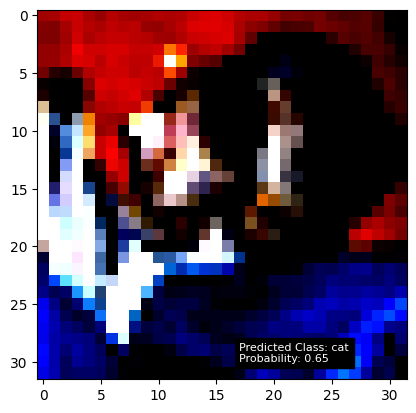

Print probabilities for each class:
airplane: 0.0016
automobile: 0.0001
bird: 0.0000
cat: 0.6550
deer: 0.0000
dog: 0.3419
frog: 0.0010
horse: 0.0001
ship: 0.0000
truck: 0.0002


In [20]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[predict_label].item()
image = input.cpu().numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[i].item():.4f}')

In [21]:
import csv

def save_dict_to_csv(filename, data_dict, path = "./result/"):
    with open(path + filename, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        
        header = data_dict.keys()
        writer.writerow(header)
        
        rows = zip(*data_dict.values())
        writer.writerows(rows)
            
def read_csv_to_dict(filename, flt = True, path = "./result/"):
    data_dict = {}
    with open(path + filename, 'r') as csv_file:
        reader = csv.DictReader(csv_file)
        print(filename)
        for row in reader:
            for key, value in row.items():
                if key not in data_dict:
                    data_dict[key] = []
                if flt:
                    data_dict[key].append(float(value))
                else:
                    numbers_str = value.strip('[]').split()
                    numbers_list = [float(num) for num in numbers_str]
                    data_dict[key].append(numbers_list)
    return data_dict

save_dict = False
if not read_ckpt or save_dict:
    save_dict_to_csv(f'train_loss_histories{NUM_EPOCHS}.csv', train_loss_histories)
    save_dict_to_csv(f'train_acc_histories{NUM_EPOCHS}.csv', train_acc_histories)
    save_dict_to_csv(f'test_loss_histories{NUM_EPOCHS}.csv', test_loss_histories)
    save_dict_to_csv(f'test_acc_histories{NUM_EPOCHS}.csv', test_acc_histories)
    save_dict_to_csv(f'test_precision_histories{NUM_EPOCHS}.csv', test_precision_histories)
    save_dict_to_csv(f'test_recall_histories{NUM_EPOCHS}.csv', test_recall_histories)
    save_dict_to_csv(f'test_f1_histories{NUM_EPOCHS}.csv', test_f1_histories)
    save_dict_to_csv(f'test_targets_histories{NUM_EPOCHS}.csv', test_targets_histories)
    save_dict_to_csv(f'test_probs_histories{NUM_EPOCHS}.csv', test_probs_histories)
    save_dict_to_csv(f'test_preds_histories{NUM_EPOCHS}.csv', test_preds_histories)
    save_dict_to_csv(f'kappas{NUM_EPOCHS}.csv', kappas)
    save_dict_to_csv(f'train_times{NUM_EPOCHS}.csv', train_times)
    save_dict_to_csv(f'test_times{NUM_EPOCHS}.csv', test_times)
else:
    train_loss_histories = read_csv_to_dict(f'train_loss_histories{NUM_EPOCHS}.csv')
    train_acc_histories = read_csv_to_dict(f'train_acc_histories{NUM_EPOCHS}.csv')
    test_loss_histories = read_csv_to_dict(f'test_loss_histories{NUM_EPOCHS}.csv')
    test_acc_histories = read_csv_to_dict(f'test_acc_histories{NUM_EPOCHS}.csv')
    test_precision_histories = read_csv_to_dict(f'test_precision_histories{NUM_EPOCHS}.csv')
    test_recall_histories = read_csv_to_dict(f'test_recall_histories{NUM_EPOCHS}.csv')
    test_f1_histories = read_csv_to_dict(f'test_f1_histories{NUM_EPOCHS}.csv')
    test_targets_histories = read_csv_to_dict(f'test_targets_histories{NUM_EPOCHS}.csv')
    test_probs_histories = read_csv_to_dict(f'test_probs_histories{NUM_EPOCHS}.csv', False)
    test_preds_histories = read_csv_to_dict(f'test_preds_histories{NUM_EPOCHS}.csv', False)
    kappas = read_csv_to_dict(f'kappas{NUM_EPOCHS}.csv')
    train_times = read_csv_to_dict(f'train_times{NUM_EPOCHS}.csv')
    test_times = read_csv_to_dict(f'test_times{NUM_EPOCHS}.csv')

train_loss_histories30.csv
train_acc_histories30.csv
test_loss_histories30.csv
test_acc_histories30.csv
test_precision_histories30.csv
test_recall_histories30.csv
test_f1_histories30.csv
test_targets_histories30.csv
test_probs_histories30.csv
test_preds_histories30.csv
kappas30.csv
train_times30.csv
test_times30.csv


In [22]:
# train_loss_histories = {}
# train_acc_histories = {}
# test_loss_histories = {}
# test_acc_histories = {}
# test_precision_histories = {}
# test_recall_histories = {}
# test_f1_histories = {}

x = NUM_EPOCHS

In [23]:
import sys
print(sys.executable)
sys.path.append('/data/root/.local/lib/python3.10/site-packages')


/usr/bin/python


In [24]:
# !python -m pip install -i https://pypi.tuna.tsinghua.edu.cn/simple --user --upgrade seaborn

# sys.path
# get_ipython().system(
#     "export PYTHONPATH=/data/root/.local/lib/python3.10/site-packages:/usr/local/lib/python3.10/dist-packages:$PYTHONPATH"
# )
# !which python
# !jupyter kernelspec list
# import seaborn as sns

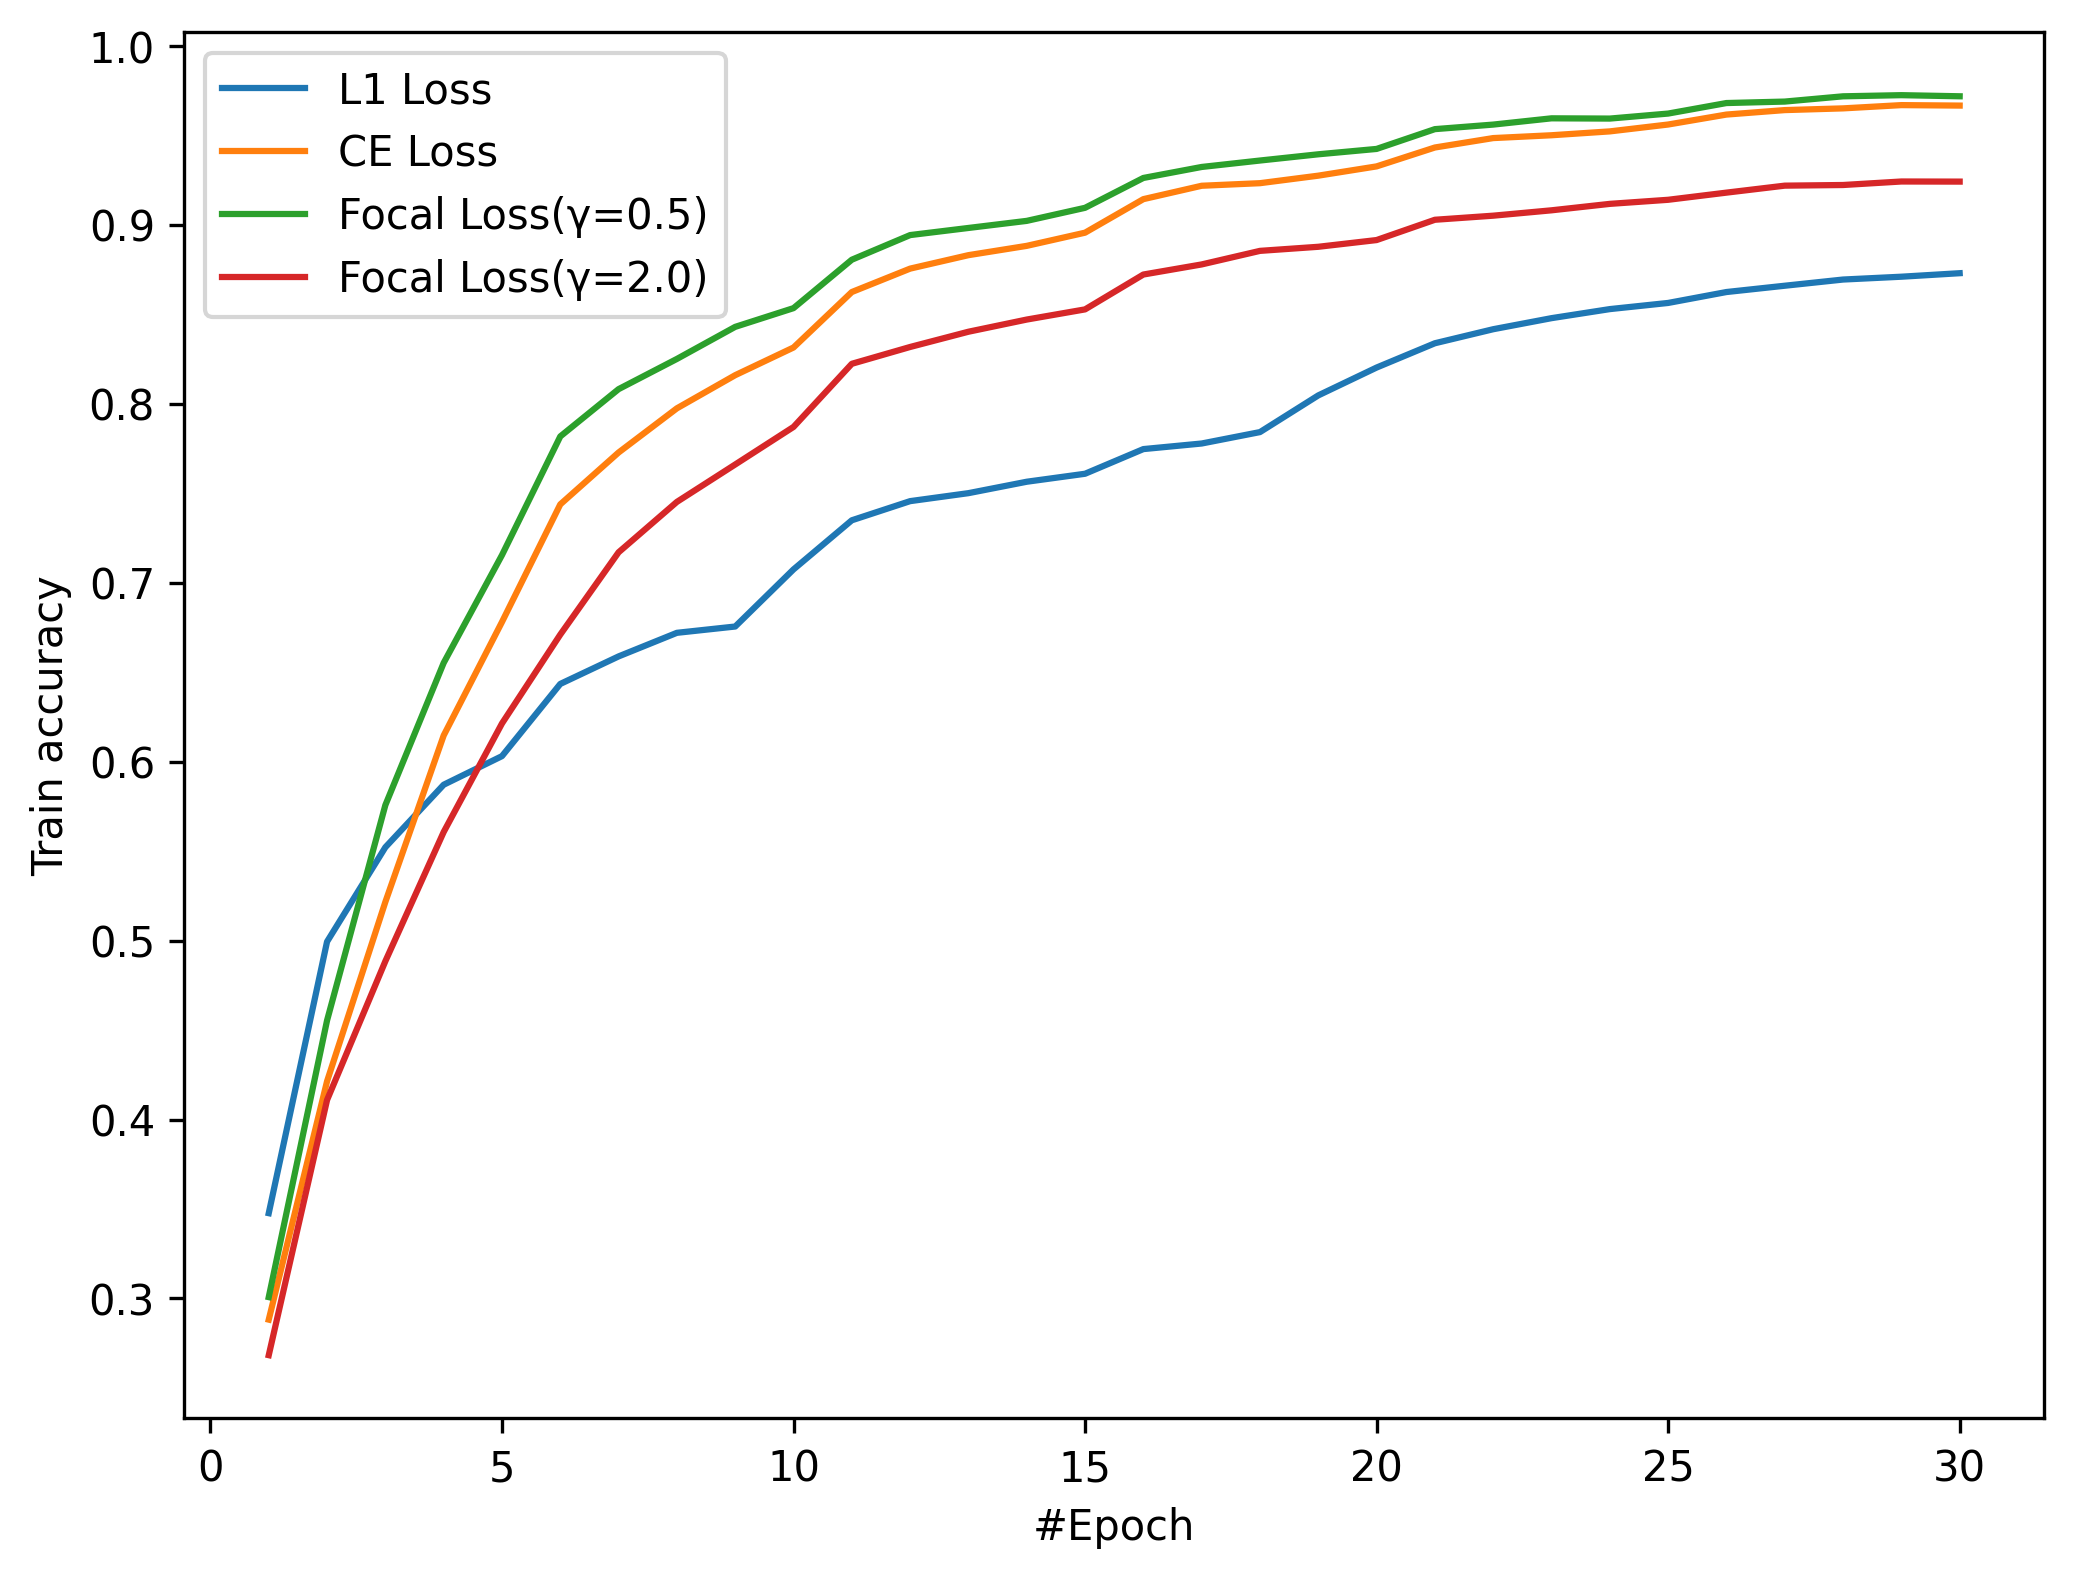

In [25]:
x = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(8, 6), dpi=300)
for legend, y in train_acc_histories.items():
    plt.plot(x, y, label = legend)
plt.xlabel("#Epoch")
plt.ylabel("Train accuracy")
plt.legend()

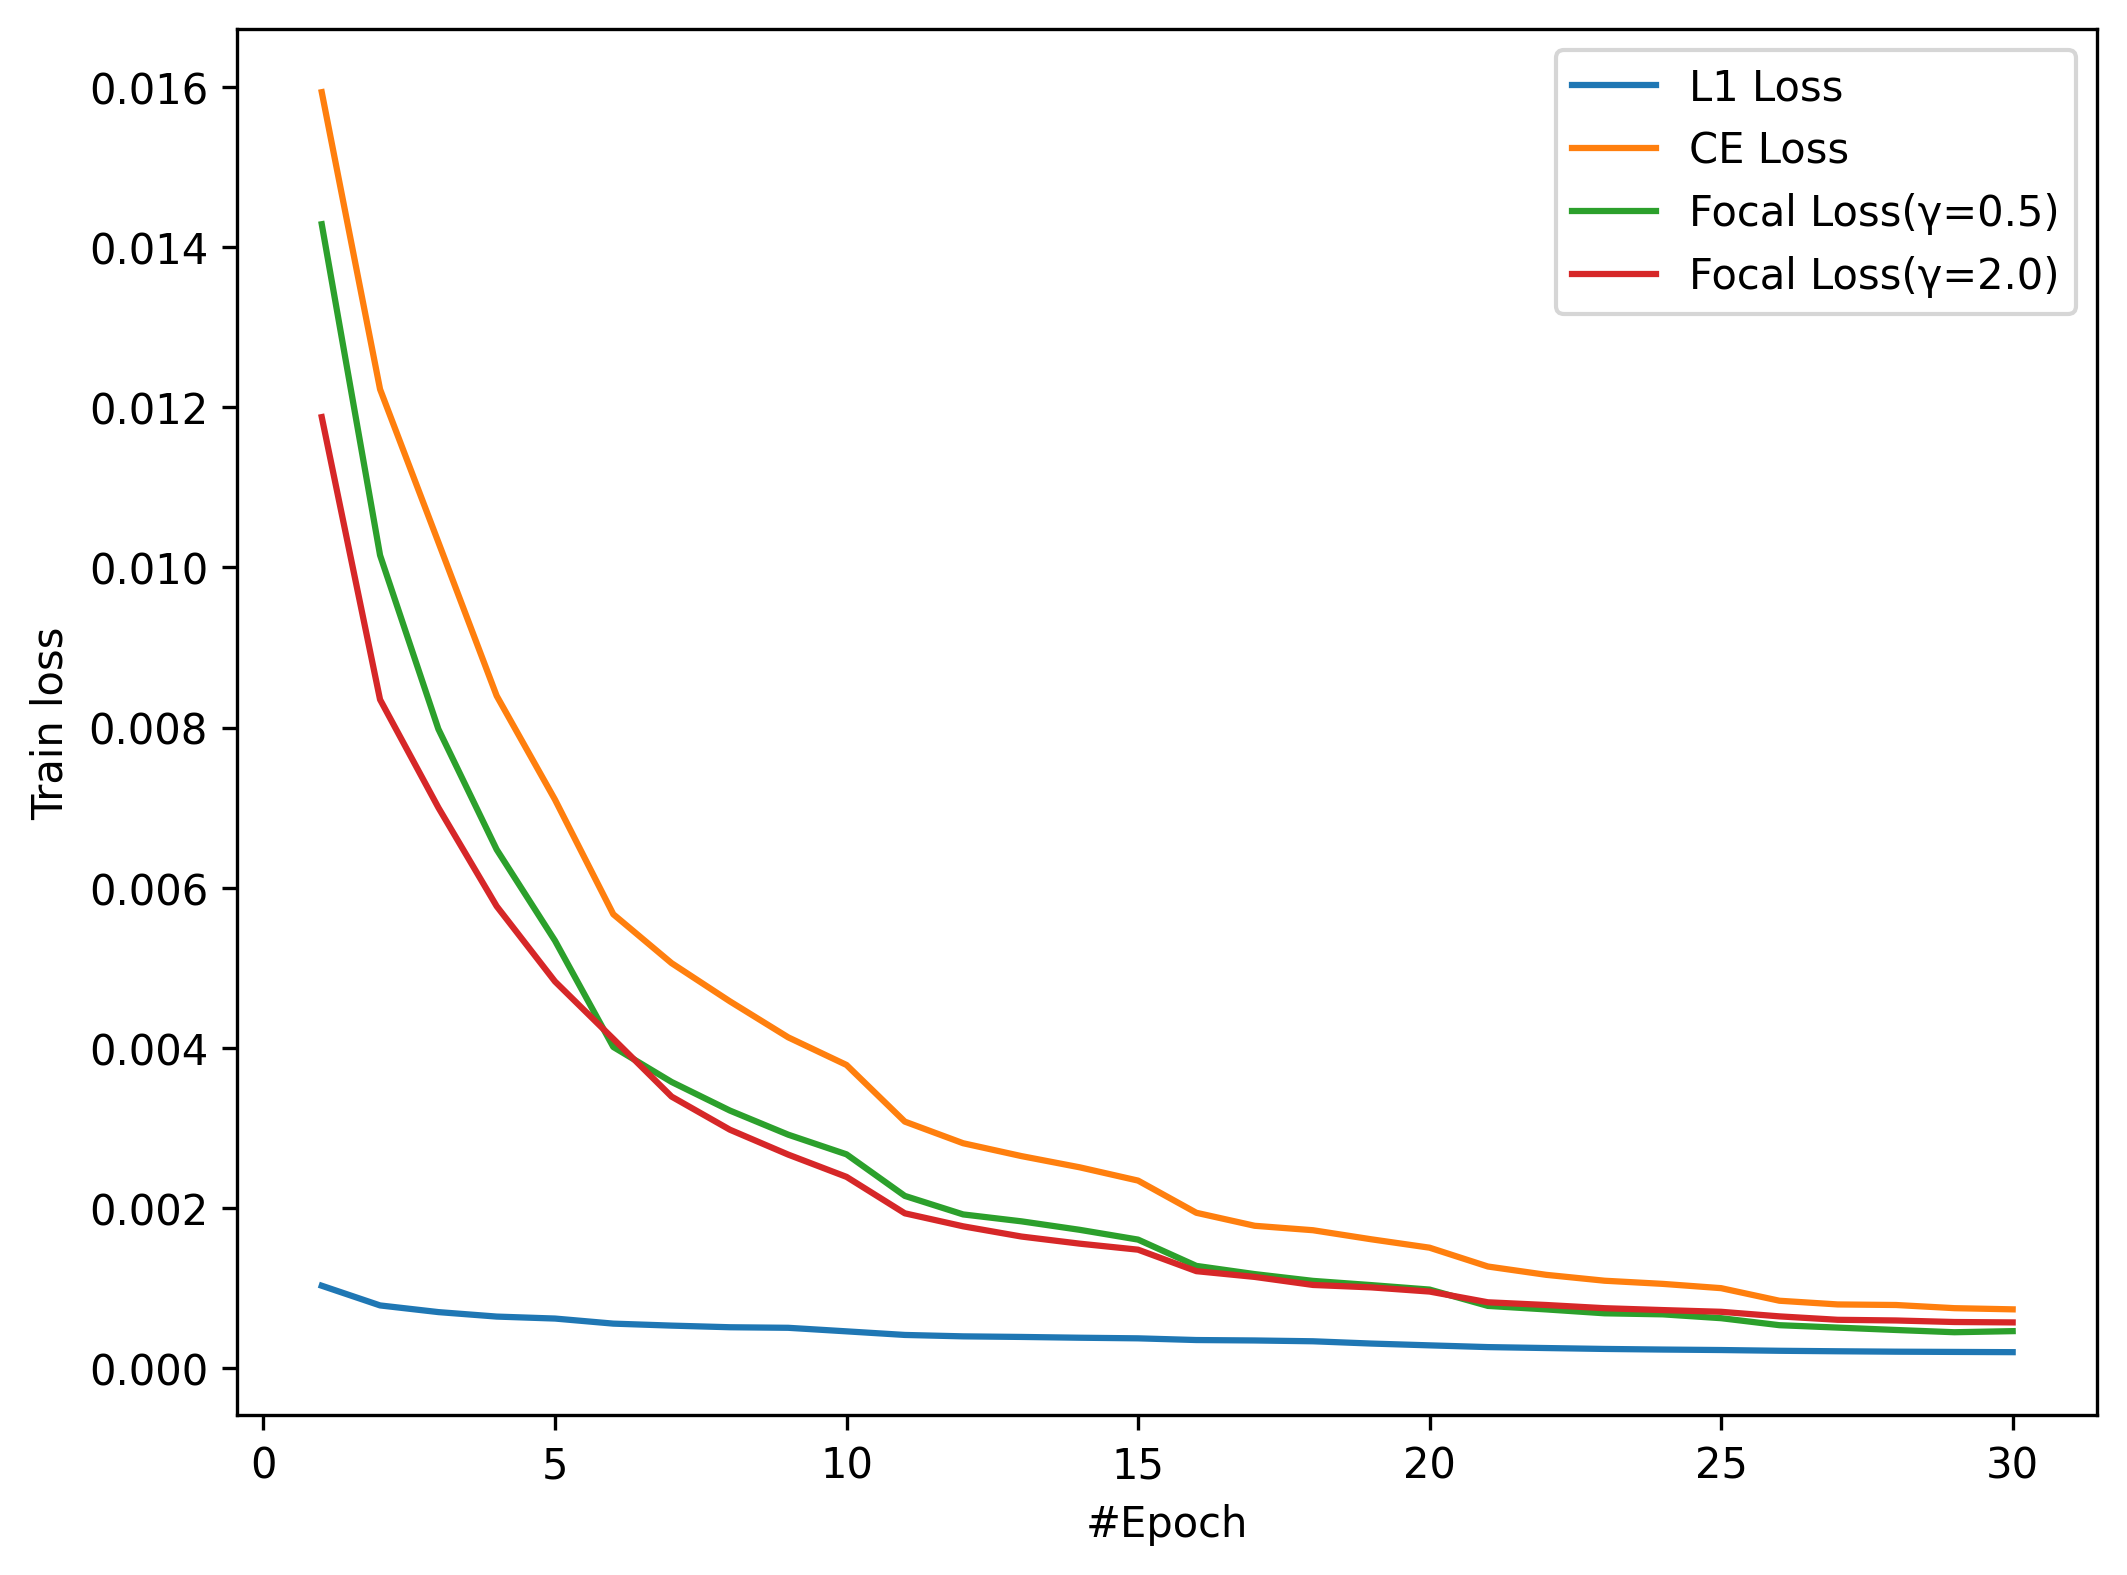

In [26]:
plt.figure(figsize=(8, 6), dpi=300)
for legend, y in train_loss_histories.items():
    plt.plot(x, y, label = legend)
plt.xlabel("#Epoch")
plt.ylabel("Train loss")
plt.legend()

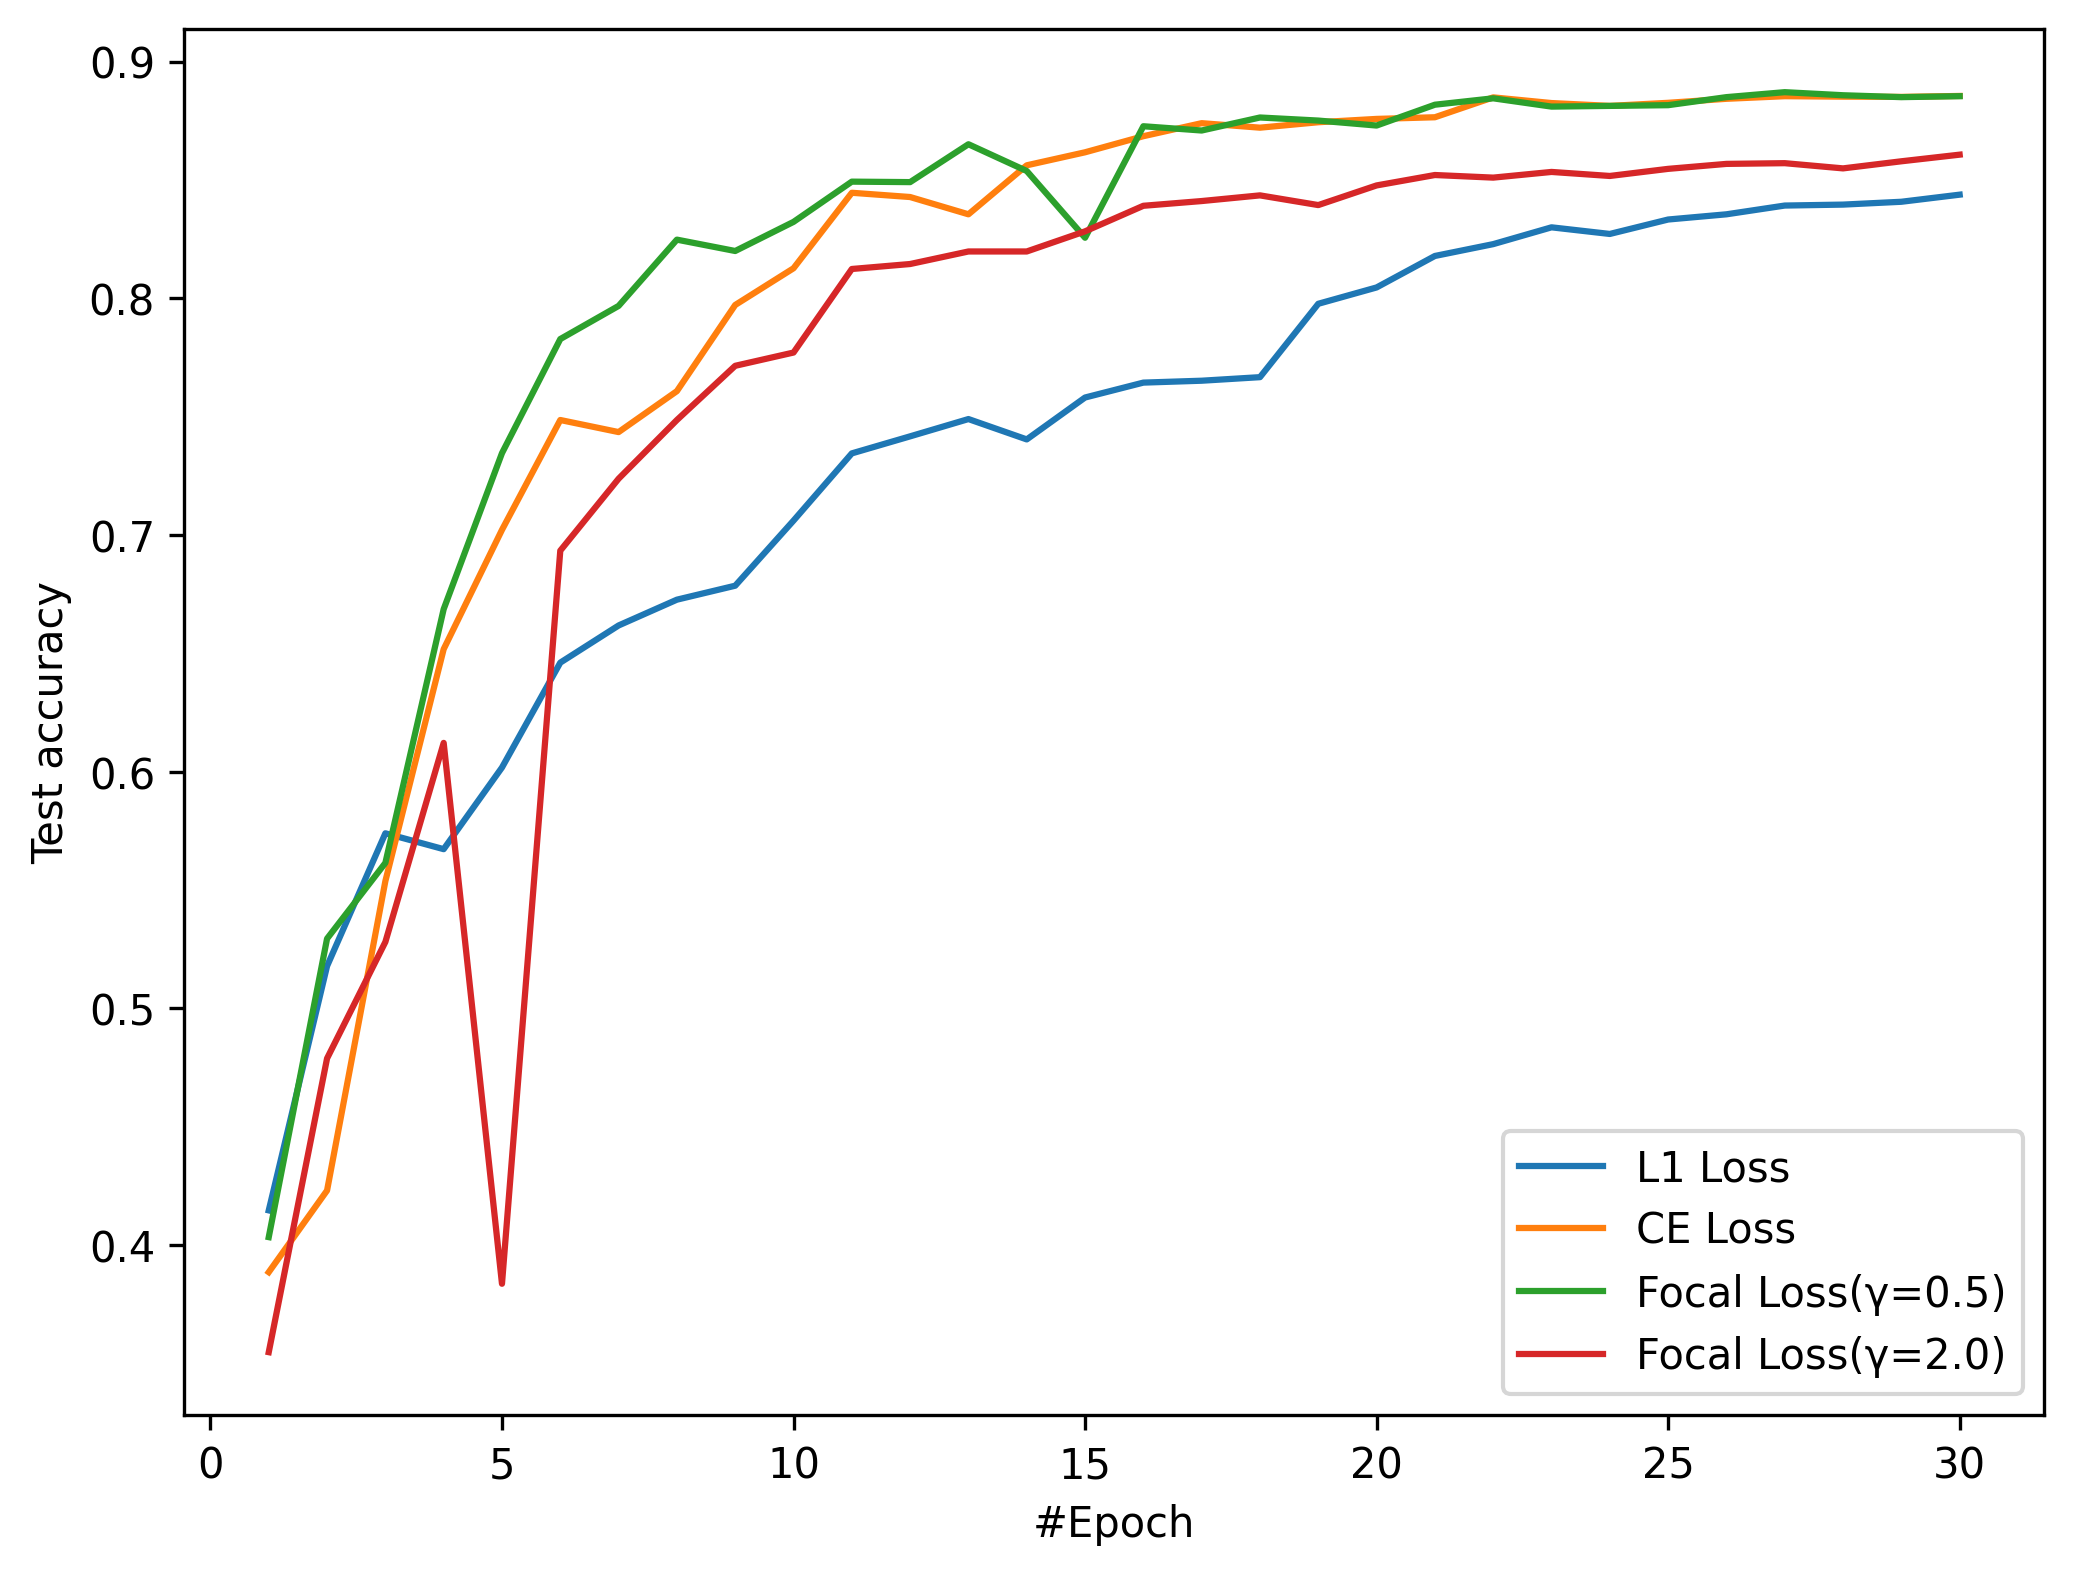

In [27]:
plt.figure(figsize=(8, 6), dpi=300)
for legend, y in test_acc_histories.items():
    plt.plot(x, y, label = legend)
plt.xlabel("#Epoch")
plt.ylabel("Test accuracy")
plt.legend()

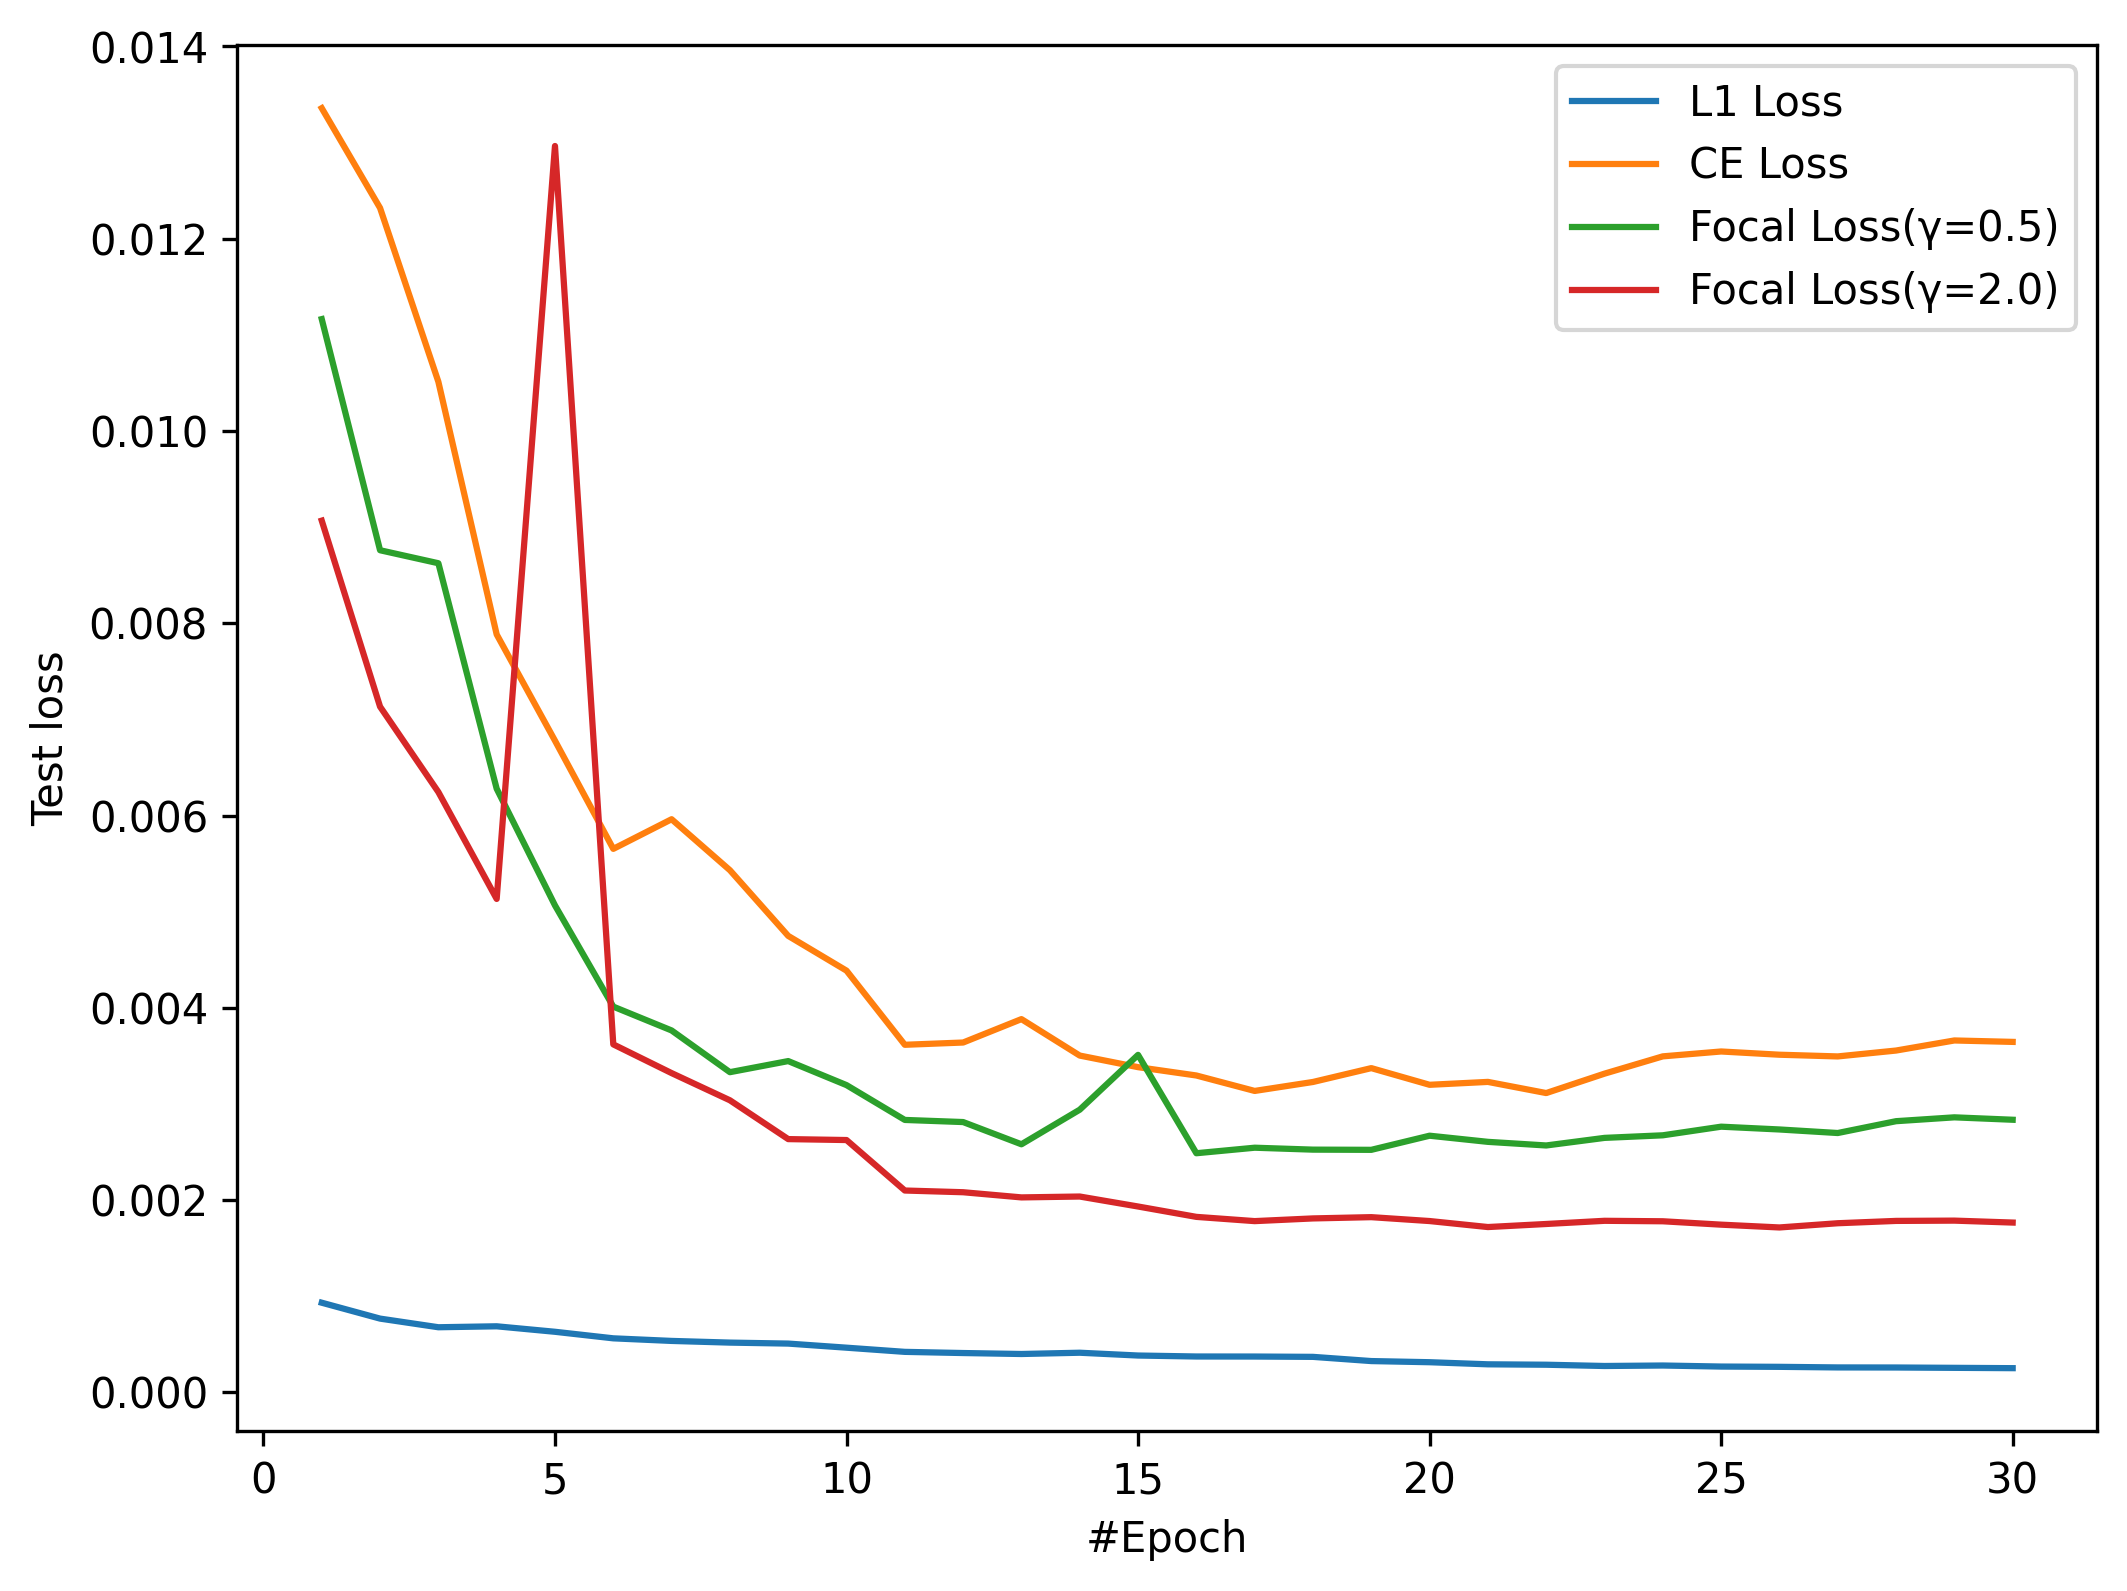

In [28]:
plt.figure(figsize=(8, 6), dpi=300)
for legend, y in test_loss_histories.items():
    plt.plot(x, y, label = legend)
plt.xlabel("#Epoch")
plt.ylabel("Test loss")
plt.legend()

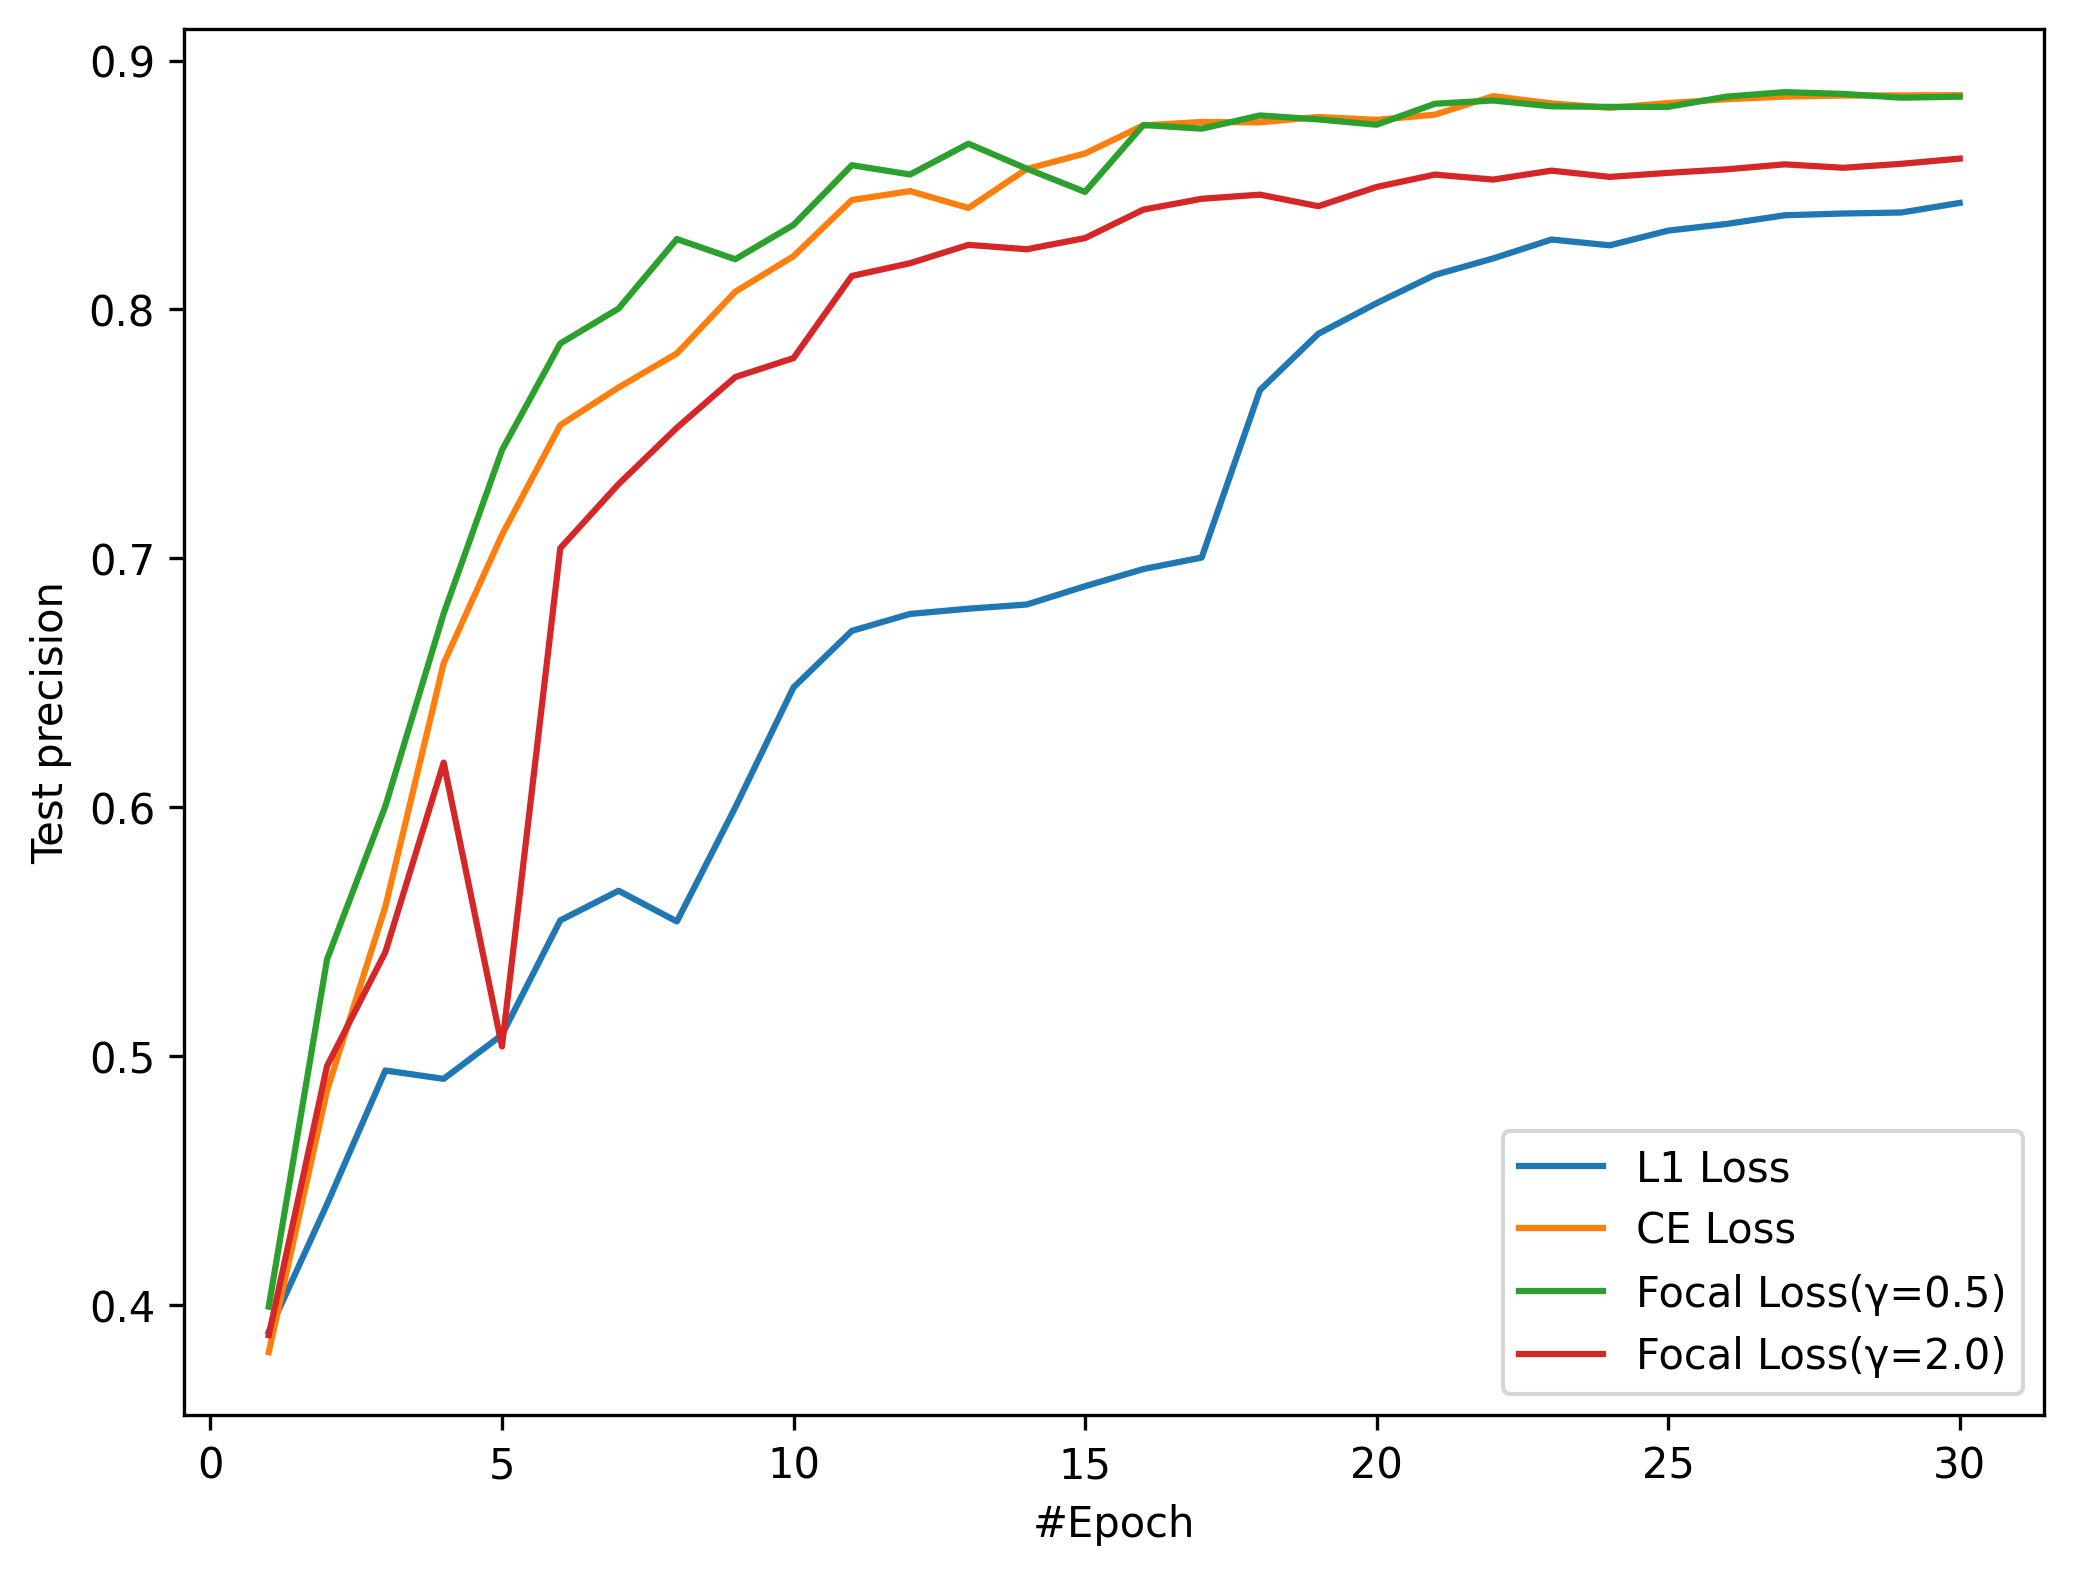

In [29]:
plt.figure(figsize=(8, 6), dpi=300)
for legend, y in test_precision_histories.items():
    plt.plot(x, y, label = legend)
plt.xlabel("#Epoch")
plt.ylabel("Test precision")
plt.legend()

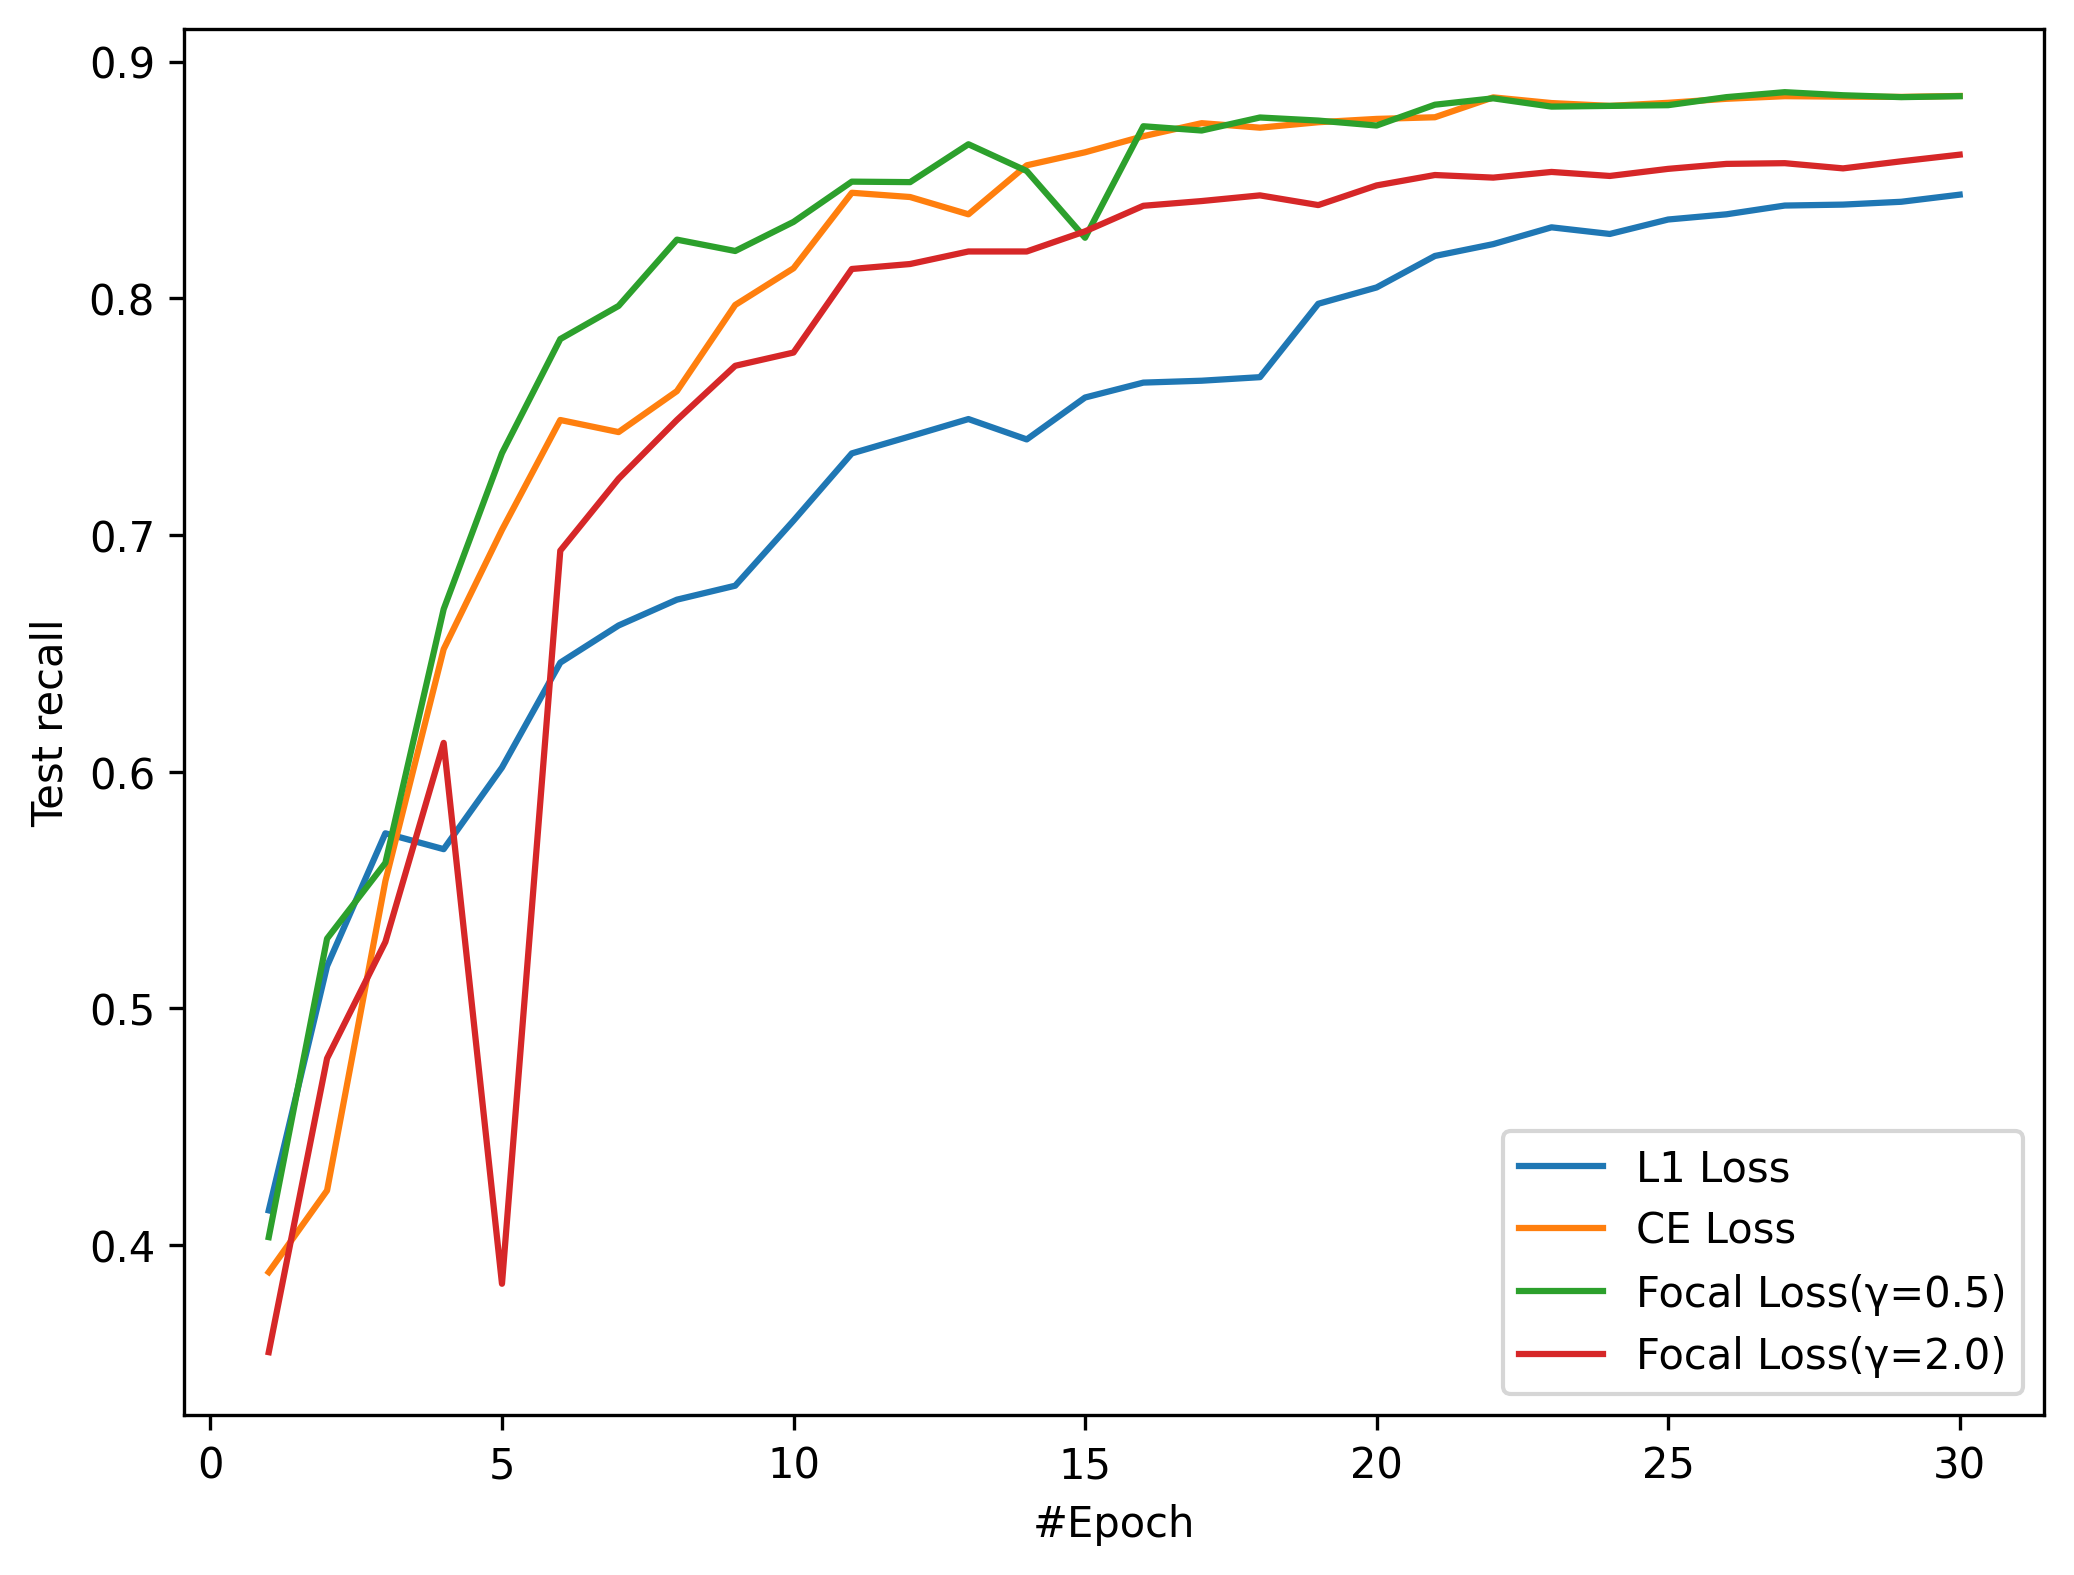

In [30]:
plt.figure(figsize=(8, 6), dpi=300)
for legend, y in test_recall_histories.items():
    plt.plot(x, y, label = legend)
plt.xlabel("#Epoch")
plt.ylabel("Test recall")
plt.legend()

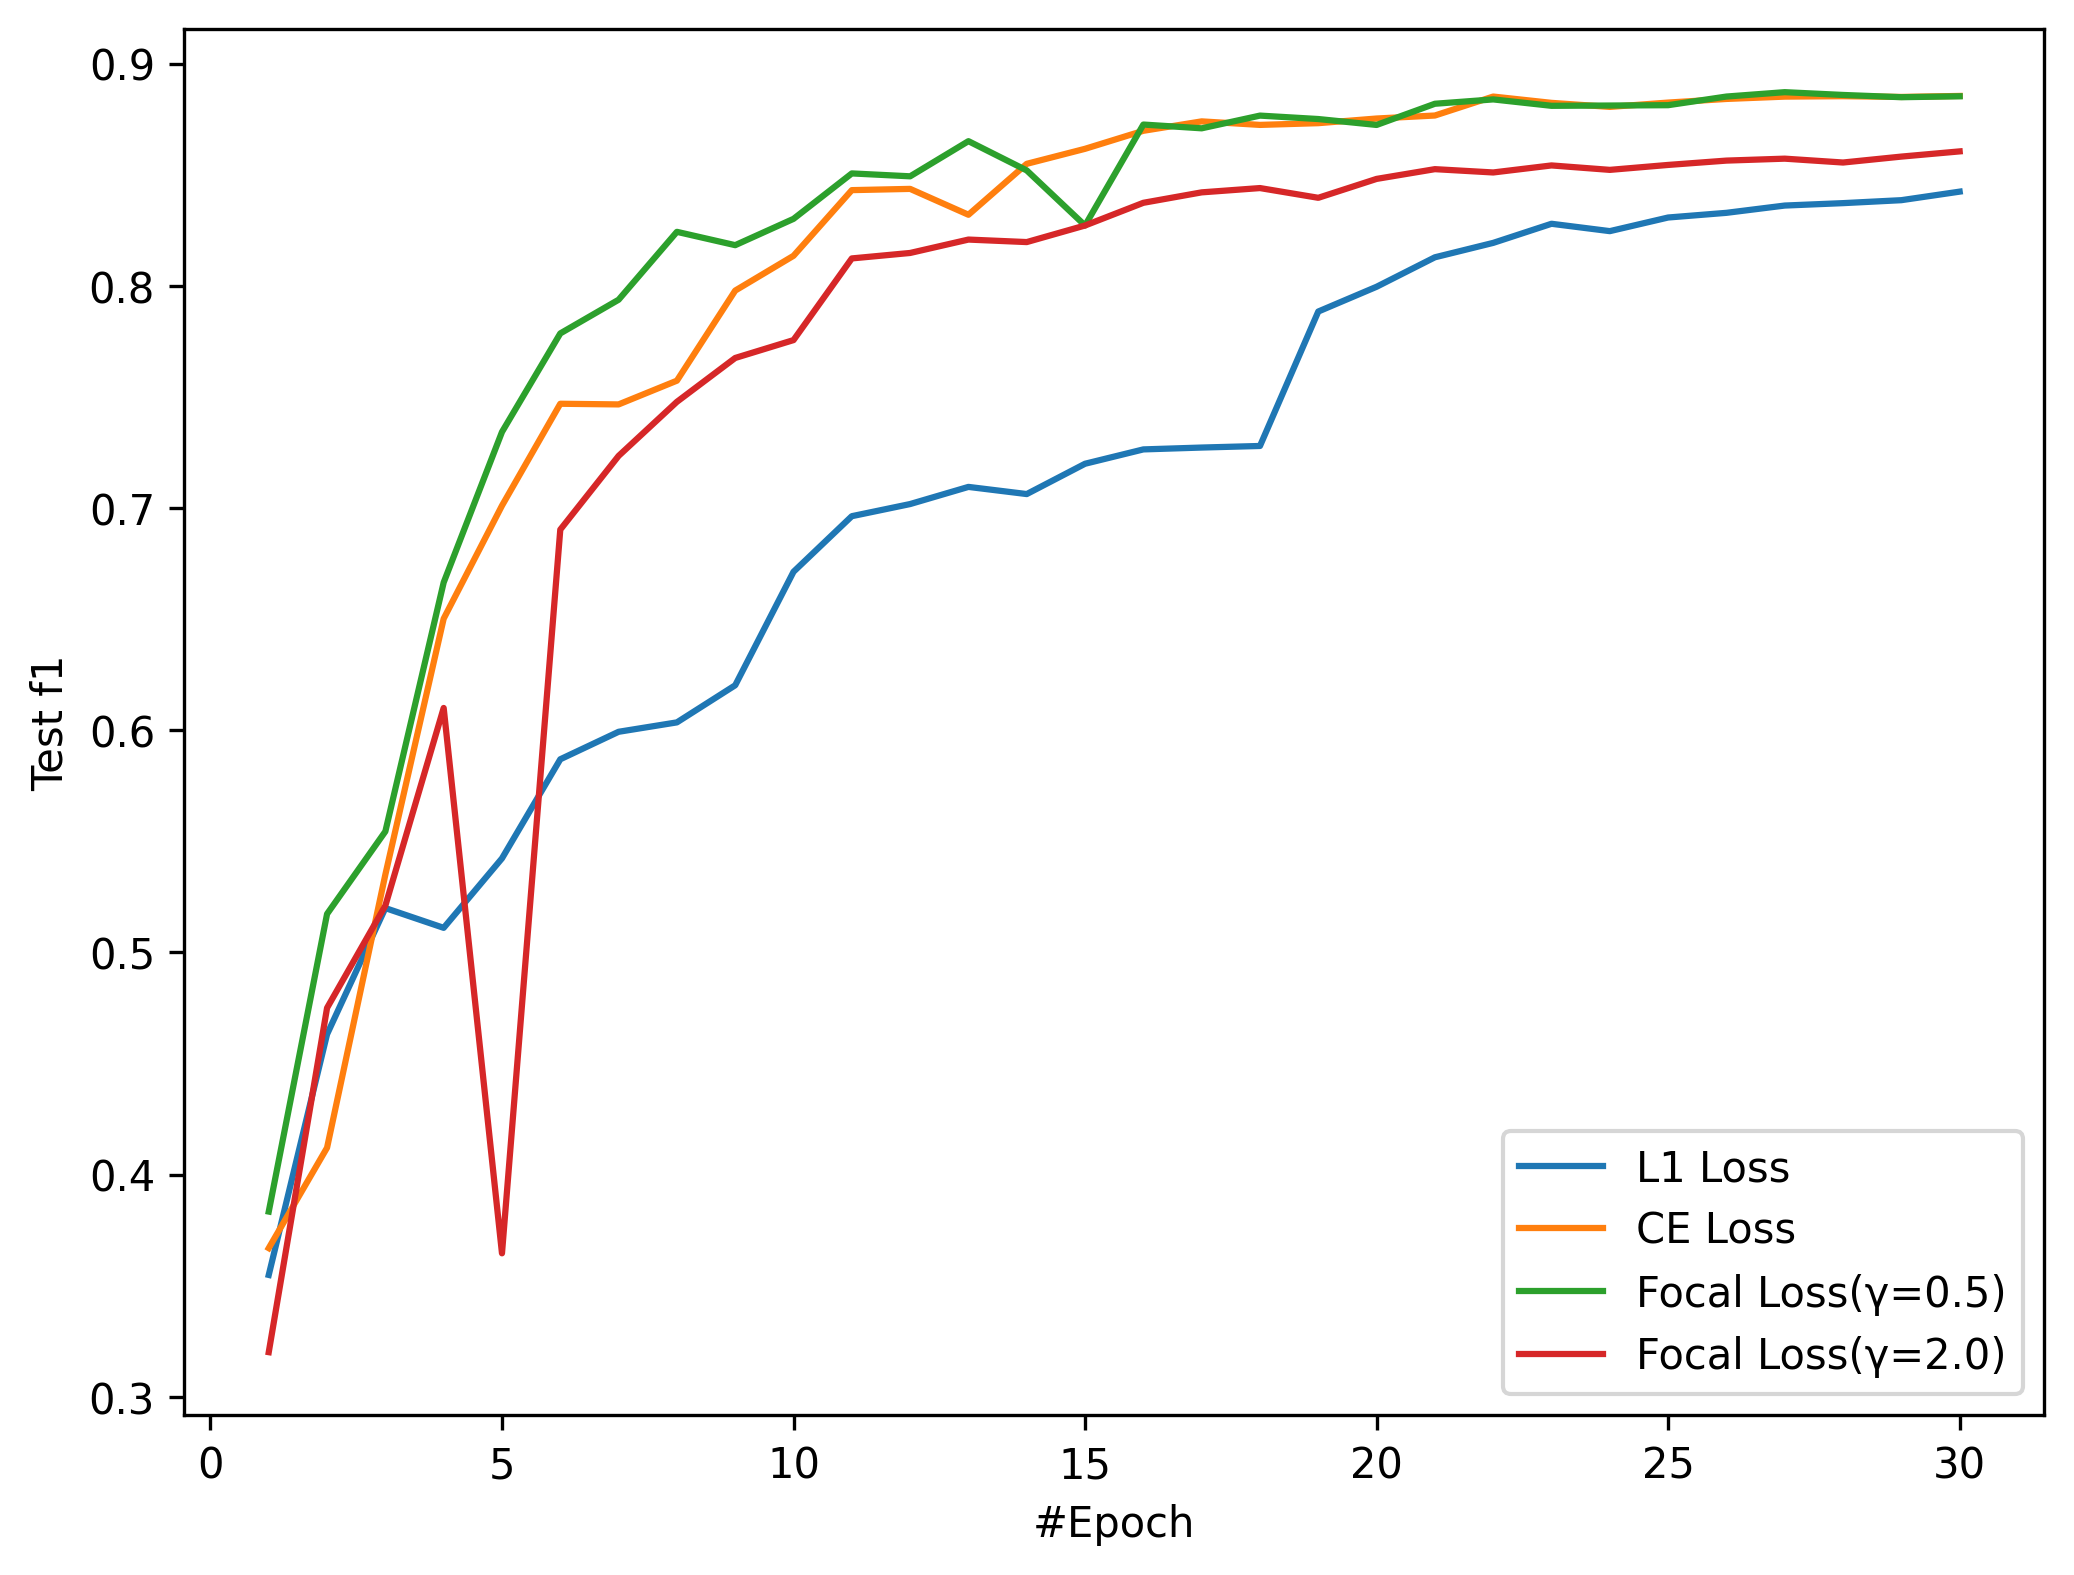

In [31]:
plt.figure(figsize=(8, 6), dpi=300)
for legend, y in test_f1_histories.items():
    plt.plot(x, y, label = legend)
plt.xlabel("#Epoch")
plt.ylabel("Test f1")
plt.legend()

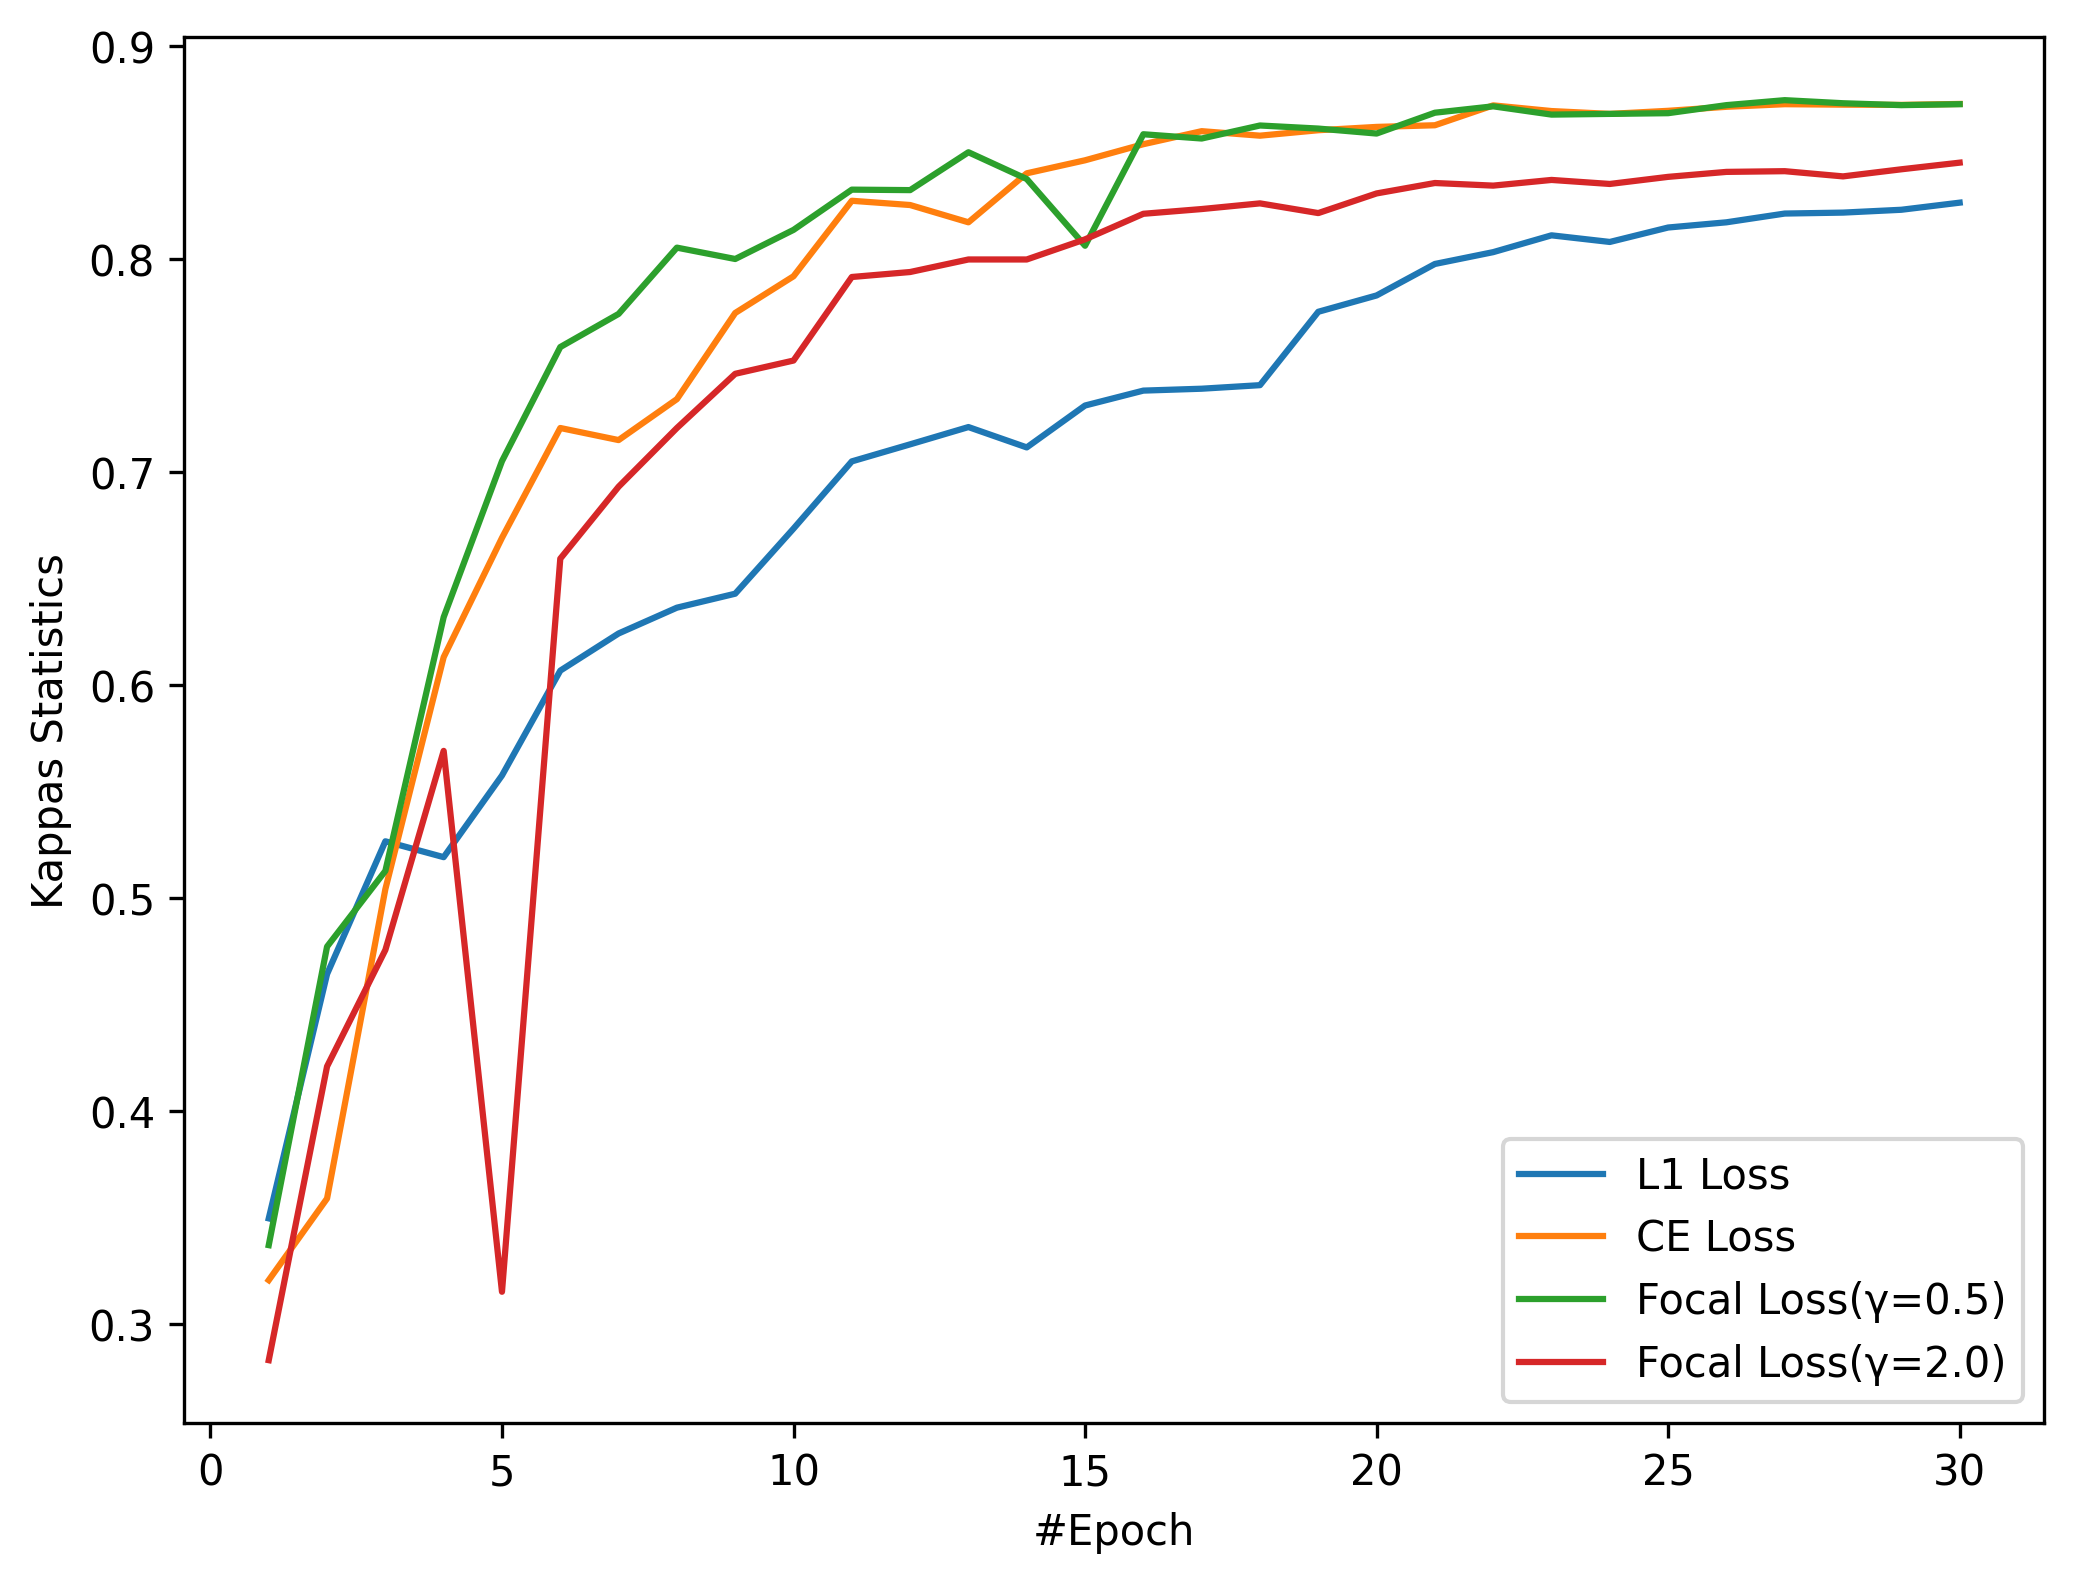

In [32]:
plt.figure(figsize=(8, 6), dpi=300)
for legend, y in kappas.items():
    plt.plot(x, y, label = legend)
plt.xlabel("#Epoch")
plt.ylabel("Kappas Statistics")
plt.legend()

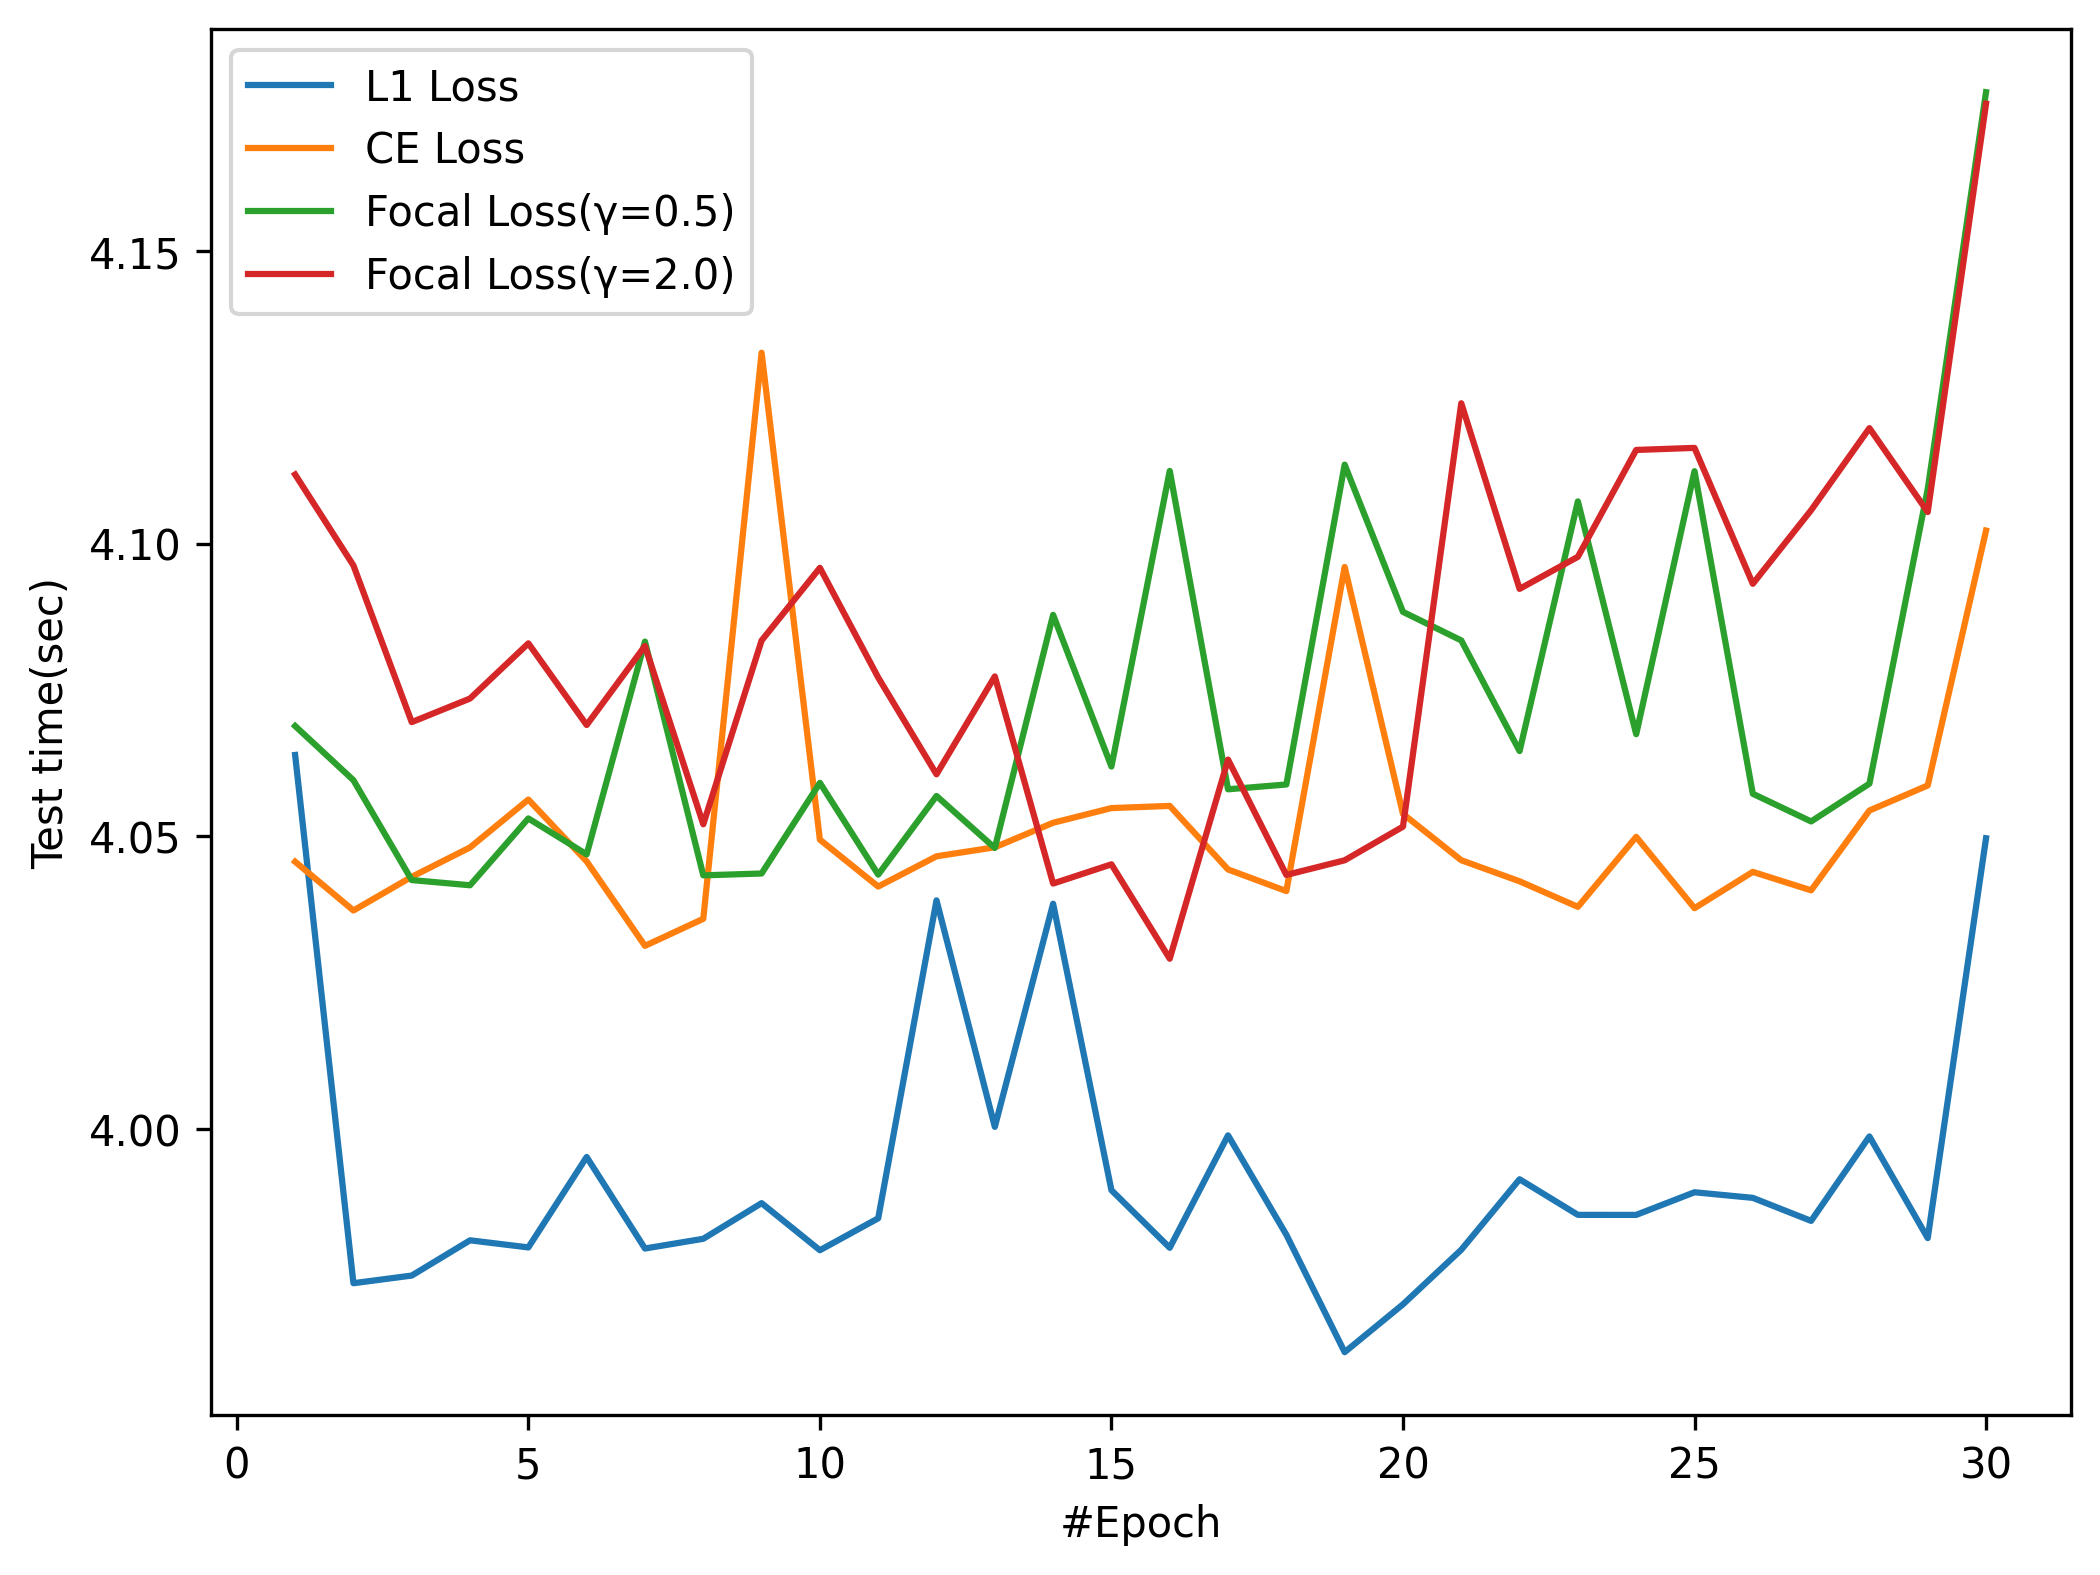

In [33]:
plt.figure(figsize=(8, 6), dpi=300)
for legend, y in test_times.items():
    plt.plot(x, y, label = legend)
plt.xlabel("#Epoch")
plt.ylabel("Test time(sec)")
plt.legend()

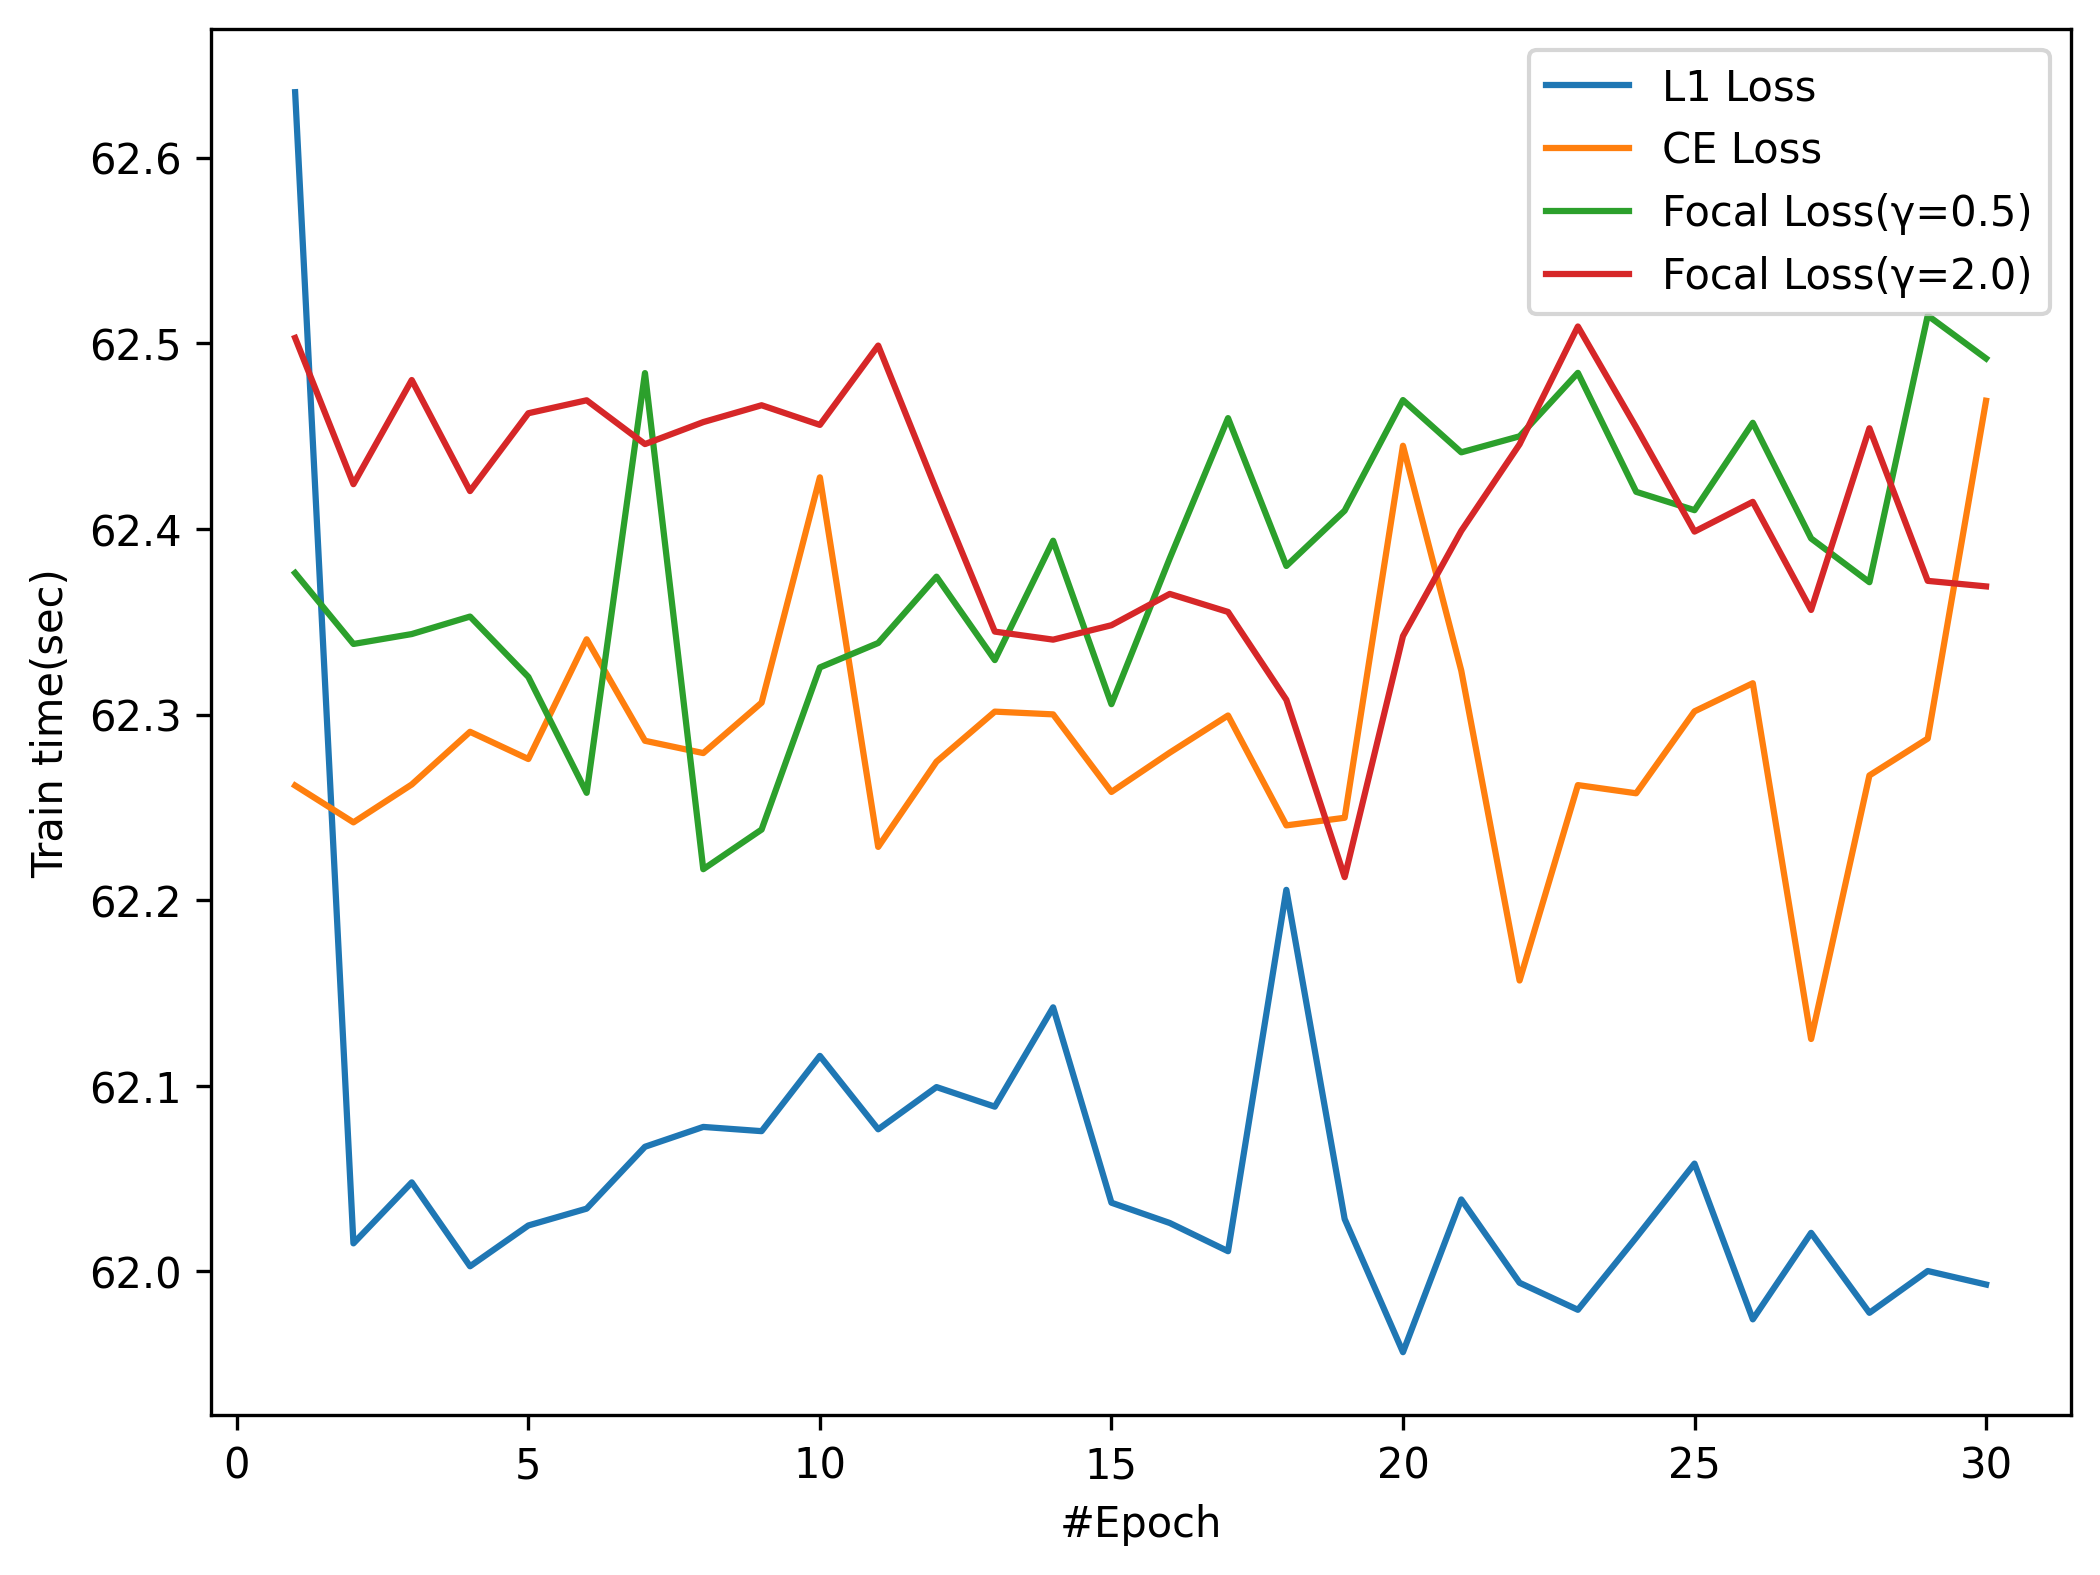

In [34]:
plt.figure(figsize=(8, 6), dpi=300)
for legend, y in train_times.items():
    plt.plot(x, y, label = legend)
plt.xlabel("#Epoch")
plt.ylabel("Train time(sec)")
plt.legend()

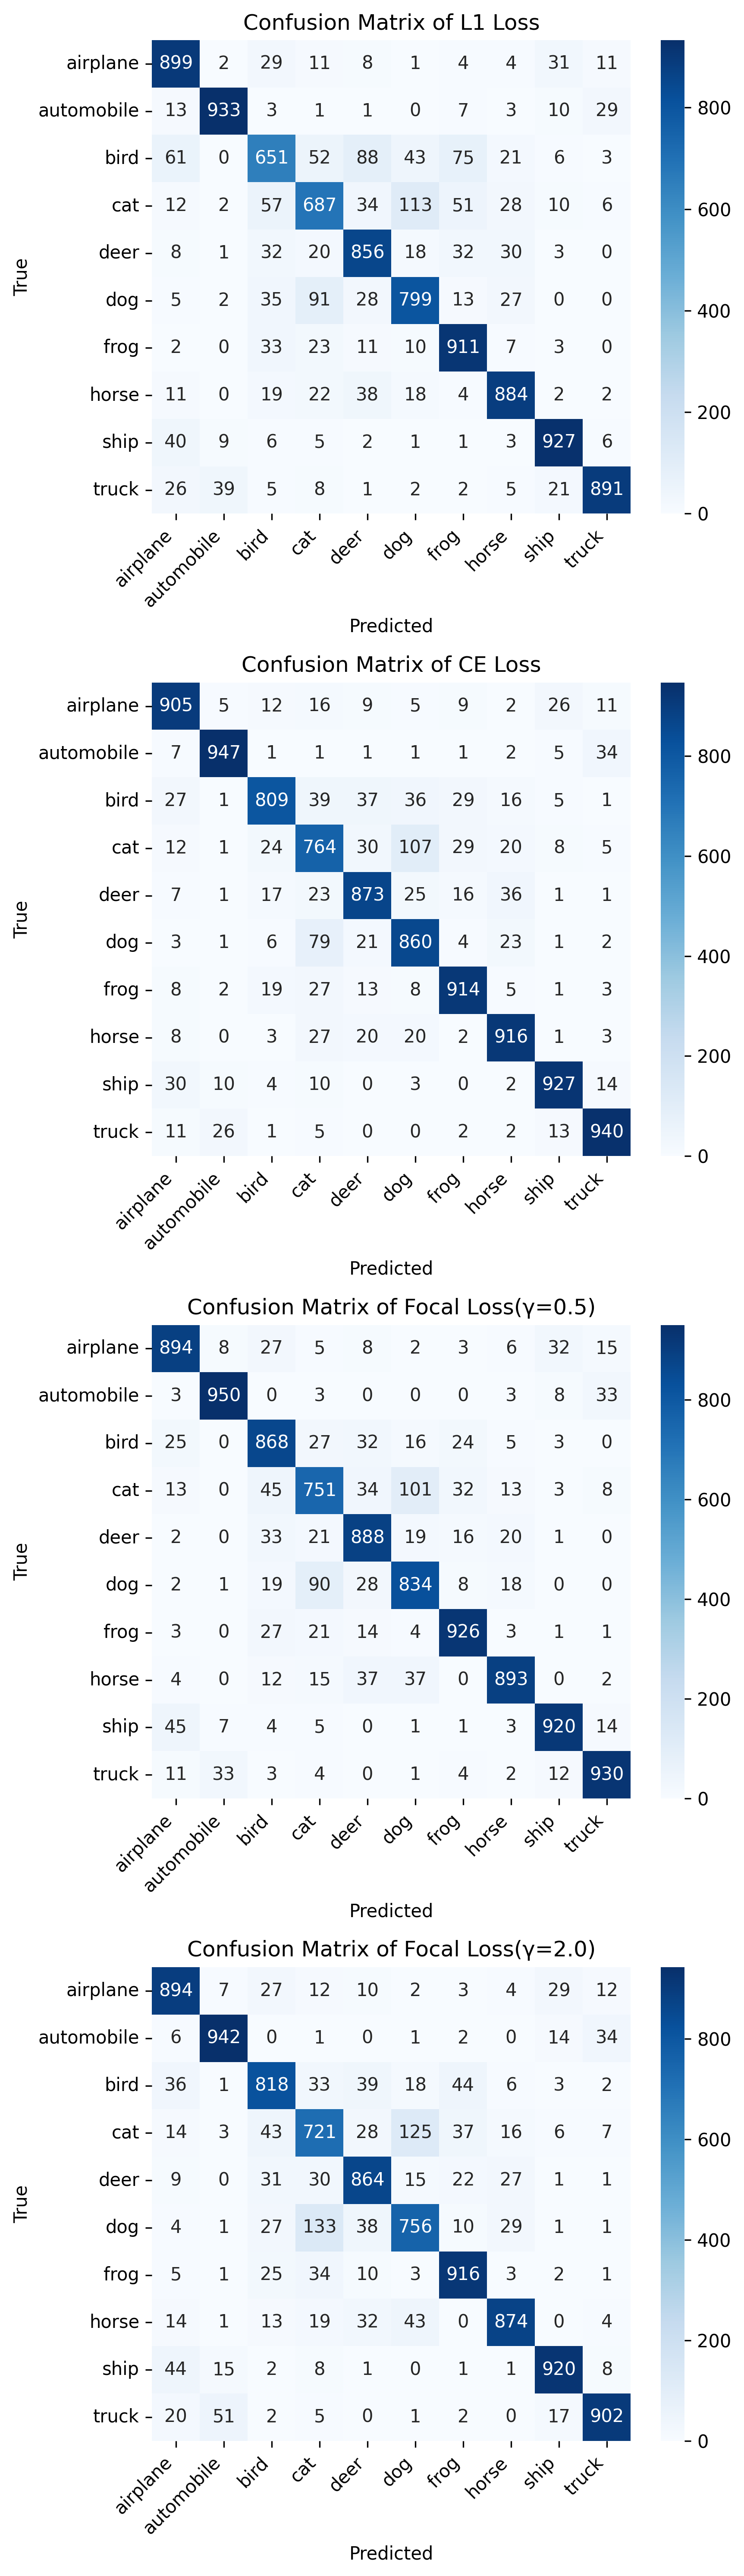

In [35]:
fig, ax = plt.subplots(4, 1, figsize=(6, 20), dpi = 300)
place_map = {
    "L1 Loss": 0,
    "CE Loss": 1,
    "Focal Loss(γ=0.5)": 2,
    "Focal Loss(γ=2.0)": 3,
}

kappas = {}

for criterion in test_targets_histories:
    test_targets = test_targets_histories[criterion]
    test_preds = test_preds_histories[criterion]
    confusion = confusion_matrix(test_targets, test_preds)

    px = place_map[criterion]
    py = 0
    sns.heatmap(confusion, annot=True, cmap="Blues", fmt='d', ax=ax[px])
    ax[px].set_xticklabels(class_names, rotation=45, ha="right")
    ax[px].set_yticklabels(class_names, rotation=0)
    ax[px].set_title(f'Confusion Matrix of {criterion}')
    ax[px].set_xlabel('Predicted')
    ax[px].set_ylabel('True')
    
    kappas[criterion] = cohen_kappa_score(test_targets, test_preds)

fig.tight_layout()

plt.rcParams['agg.path.chunksize'] = 0 
plt.show()

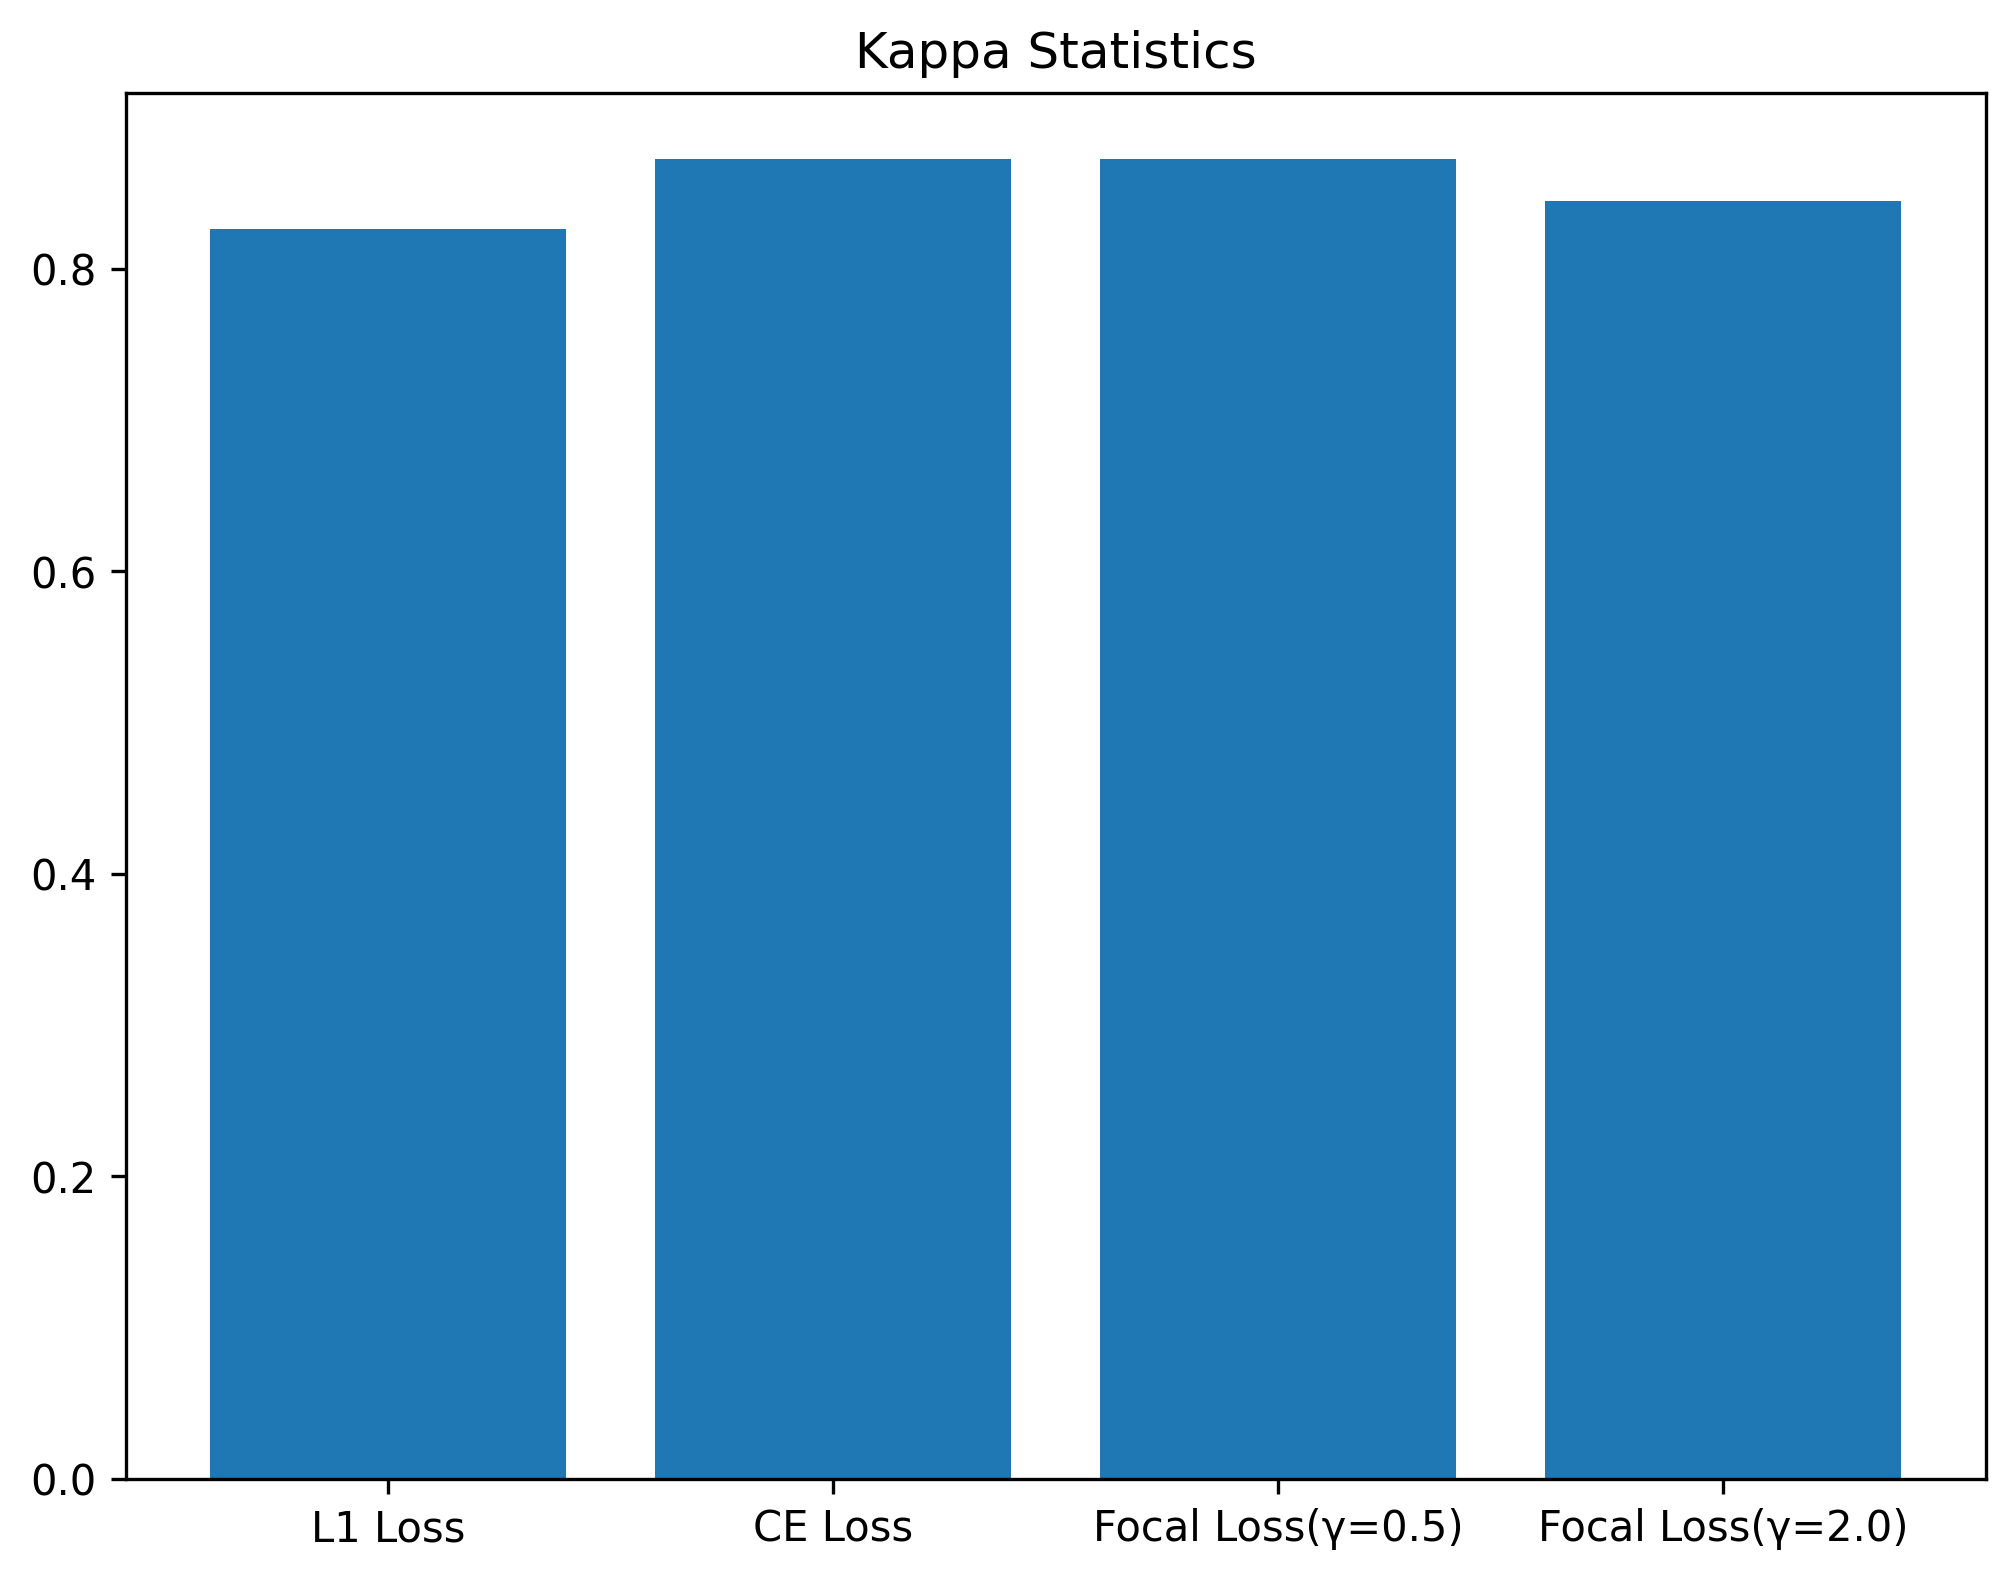

In [36]:
plt.figure(figsize=(8, 6), dpi=300)
plt.bar(list(kappas.keys()), list(kappas.values()))
plt.title("Kappa Statistics")
plt.show()